#Consigna



Entrenar un modelo de segmentación basado en la arquitectura U-Net para resolver el problema de segmentación de neumotórax. 

Los datos se pueden descargar directamente a una máquina virtual (VM) de colab desde Kaggle. El instructivo para hacerlo (tener en cuanta que hay que descargar otra vez cuando termina la sesión). 

Se usarán los datos de:

https://www.kaggle.com/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks

Reportar la métrica de Dice para un conjunto de test a definir, el mismo dataset provee de un conjunto de imágenes de testeo. Puede usarse ese conjunto o separar un conjunto propio a partir de todos los datos.

Para este TP no hay una métrica objetivo a alcanzar, se intenta en lo posible que la métrica de Dice sea lo más cercana a 1. Reportar el modelo con mejor desempeño (hiperparámetros utilizados, si se usó aumentación de datos y qué tipo de aumentación, etc...) y mostrar algunos ejemplos de segmentación. No es necesario hacer un submit a Kaggle. 

Recomendaciones:

* Trabajar a partir de la notebook de segmentación vista en clase.
* Se puede entrenar y evaluar solamente con las imágenes que contengan patologías.








#Drive e importacion de librerias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary
import numpy as np
import datetime
!pip install isoweek
from isoweek import Week
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
!pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Dataset

Se genera un directorio de nombre siim-acr-pneumothorax. El contenido de este directorio son dos dataframes en formato .csv para las imágenes de train y test y dos directorios que contienen imágenes y sus máscaras de segmentación correspondientes. Las imágenes y las máscaras tienen un patrón de nombre formado por:

ID_SET_PAT_.png

Donde ID es un número de identificación, SET indica si la imagen pertenece al conjunto de "train" o "test" y PAT puede tomar los valores 0 o 1. 0 en el caso que esa imagen no contenga neumotórax y 1 en caso de que sí contenga patología. Este dataset se compone de 10675 imágenes de entrenamiento y 1372 de testeo.

Se utilizaron dos casos de dataset, el primero con 64 imagenes (elegidas aleatoriamente) de train y test y 64 masks train y test, todas con patalogia. Y para el segundo caso se hizo lo mismo pero con 2000 imagenes.

In [15]:
from PIL import Image
import numpy as np
import albumentations as A
from pathlib import Path
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
#!cp -R "/content/drive/Shareddrives/Redes de Piluchina/TP 3/dataset_2/siim-acr-pneumothorax/"* /content/data

In [ ]:
#path_data ="/content/data/"

In [ ]:
path_nuevoDataset = "/content/drive/Shareddrives/Redes de Piluchina/TP 3/dataset/siim-acr-pneumothorax/"

Dataset de 64 imagenes

In [ ]:
import random
def reducir_dataset_train(path,cant_elementos = 64):
  filenames = [file.name for file in Path(path).glob('png_image/img/*train_1_.png')]
  new_filenames = random.sample(filenames, cant_elementos)
  for file in new_filenames:
    img = Image.open(path+"png_image/img/"+file)
    img.save("/content/data_reducida_images/"+file)
    mask = Image.open(path+"png_masks/img/"+file)
    mask.save("/content/data_reducida_masks/"+file)
  print("Len random element is :", len(new_filenames))

Dataset de 2000 imagenes

In [ ]:
import random
def reducir_dataset_train_2(path,cant_elementos = 2000):
  filenames = [file.name for file in Path(path).glob('png_image/img/*train_1_.png')]
  new_filenames = random.sample(filenames, cant_elementos)
  for file in new_filenames:
    img = Image.open(path+"png_image/img/"+file)
    img.save("/content/data_reducida_images_2/"+file)
    mask = Image.open(path+"png_masks/img/"+file)
    mask.save("/content/data_reducida_masks_2/"+file)
  print("Len random element is :", len(new_filenames))

In [ ]:
#reducir_dataset_train(path_nuevoDataset)

Len random element is : 64


In [ ]:
#reducir_dataset_train_2(path_nuevoDataset)

Len random element is : 2000


Se abren algunas imagenes del dataset para ver como son.

In [ ]:
img1 = Image.open(path_nuevoDataset+"png_image/img/10_train_1_.png")
mask1 = Image.open(path_nuevoDataset+"png_masks/img/10_train_1_.png")

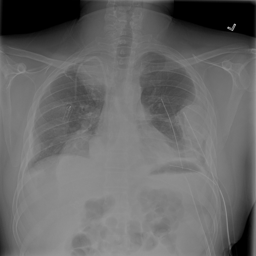

In [ ]:
img1.resize((256,256))

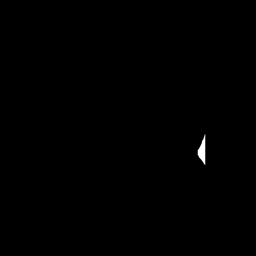

In [ ]:
mask1.resize((256,256))

## Data-Augmentation

Dado que en general las redes Neuronales tienen grandes cantidades de parametros, necesitamos tener una cantidad proporcional de data a la cantidad de parametros para tener una buena performance. Por eso, se usa lo que se conoce como Data Augmentation que consiste en hacer alteraciones menores sobre el dataset para obtener más cantidad imagenes.

Estás alteraciones pueden ser: Flips, translations, rotations, entre otras, ya que nuestra red neuronal igualmente las va a distinguir como imagenes diferentes.

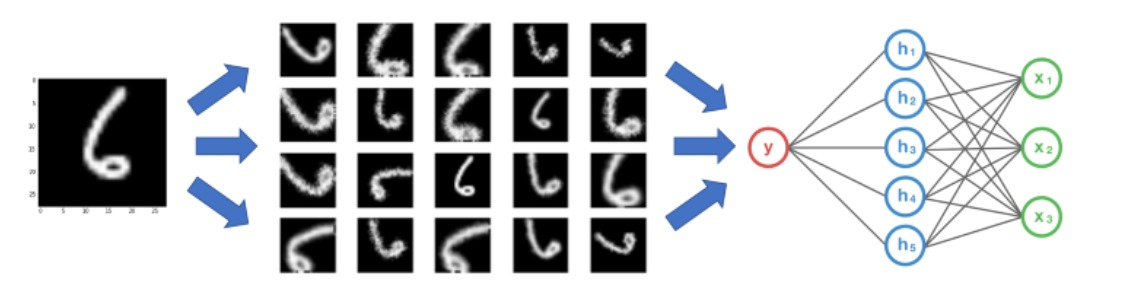

In [ ]:
#VECTOR DE TRANSFORMACION DE DATA-AUGMENTATION

transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    
])
#transform = False

#Generar data

Explicar que es un generetor, esto es para no tener todas las imagenes almacenadas,esto pasa cuando tenes muchos datos.

Hoy en día en el campo del Machine Learning cada vez se vuelve un problema más frecuente el hecho de tener que usar grandes datasets. El inconveniente es que al estar trabajando con imagenes el procesamiento por parte del modelo va a ocupar mucha memoria RAM, al usar un generador se evita tener el dataset entero ocupando espacio de forma necesaria.
Lo que se hace es generar un conjunto de datos en múltiples núcleos en tiempo real y alimentarlo de inmediato al modelo de red.

In [22]:
import tensorflow as tf
 
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(128,128), train=True,n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        if train:
            self.filenames = [file.name for file in Path(path).glob("data_reducida_images/*.png")]
        else:
            self.filenames = [file.name for file in Path(path).glob("png_image/img/*test_1_.png")]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            if self.transform:
                trf = self.transform(image = np.array(img), mask = np.array(mask))
                X[i,...] = trf['image'].reshape(*self.dim, self.n_channels)/255.
                y[i,...] = trf['mask'].reshape(*self.dim, self.n_channels)/255.
            else:
                X[i,...] = np.array(img).reshape(*self.dim, self.n_channels)/255.
                y[i,...] = np.array(mask).reshape(*self.dim, self.n_channels)/255.
        return X,y

In [21]:
import tensorflow as tf
 
class DataGenerator_2(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(64,64), train=True,n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        if train:
            self.filenames = [file.name for file in Path(path).glob("data_reducida_images_2/*.png")]
        else:
            self.filenames = [file.name for file in Path(path).glob("png_image/img/*test_1_.png")]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            if self.transform:
                trf = self.transform(image = np.array(img), mask = np.array(mask))
                X[i,...] = trf['image'].reshape(*self.dim, self.n_channels)/255.
                y[i,...] = trf['mask'].reshape(*self.dim, self.n_channels)/255.
            else:
                X[i,...] = np.array(img).reshape(*self.dim, self.n_channels)/255.
                y[i,...] = np.array(mask).reshape(*self.dim, self.n_channels)/255.
        return X,y

Esta clase Generador es la que se pasara al modelo a fitear. A medida que se arman los batchs de entrenamiento, a cada imagen se le aplica:

- Una reducción de resolución.Por un tema de rápidez de procesamiento y poder agrandar el batch_size con el que se trabaja, se buscó hacer una reducción de resolución con la mínima cantidad de perdida de información posible, es por esto que se utilizo la dimension (128,128)


- Se le aplica la transformacion del Data Augmentation, excepto para el validation

- Cuando se usaron 64 imagenes se eligio un bachsize de 32, mientras que cuando se usaron 2000 imagenes se uso un bachsize de 64.


### Generacion data TRAIN

* Dataset de 64

In [ ]:
# tener cuidado con la selección del tamaño del batch. Al iniciar el entrenamiento
# dependiendo del tamaño de la red y el tamaño del batch, puede surgir un error OOM
# (out of memory) debido a las limitaciones de RAM de la GPU.
# En tal caso se deberá achicar el tamaño del batch
datagen_1_False = DataGenerator(
    "/content/",
    "data_reducida_images/",
    "data_reducida_masks/",
    transform = False,
    shuffle= True,
    batch_size = 32,
    train = True  
)

In [ ]:
len(datagen_1_False)

2

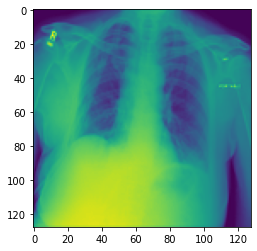

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(datagen_1_False[0][0][0].reshape(128,128))

In [ ]:
datagen_1_True = DataGenerator(
    "/content/",
    "data_reducida_images/",
    "data_reducida_masks/",
    transform = transform,
    shuffle= True,
    batch_size = 32,
    train = True  
)

In [ ]:
len(datagen_1_True)

2

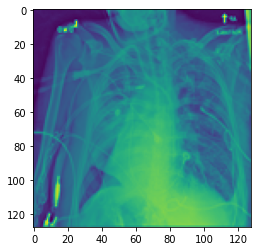

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(datagen_1_True[0][0][0].reshape(128,128))

* Dataset 2000

In [ ]:
datagen_2_False = DataGenerator_2(
    "/content/",
    "data_reducida_images_2/",
    "data_reducida_masks_2/",
    transform = False,
    shuffle= True,
    batch_size = 64,
    train = True  
)

In [ ]:
len(datagen_2_False)

31

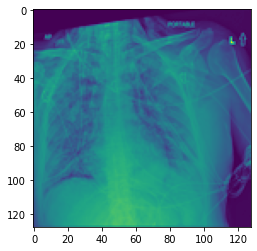

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(datagen_2_False[0][0][0].reshape(128,128))

In [ ]:
datagen_2_True = DataGenerator_2(
    "/content/",
    "data_reducida_images_2/",
    "data_reducida_masks_2/",
    transform = transform,
    shuffle= True,
    batch_size = 64,
    train = True  
)

In [ ]:
len(datagen_2_True)

31

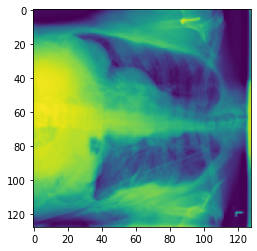

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(datagen_2_True[10][0][0].reshape(128,128))

### Generacion data VALIDATION

* Dataset 64

In [ ]:
datagen_val_1 = DataGenerator(
    "/content/",
    "data_reducida_images/",
    "data_reducida_masks/",
    transform = False,
    shuffle= True,
    batch_size = 32,
    train = True, 
)

* Dataset 2000

In [ ]:
datagen_val_2 = DataGenerator_2(
    "/content/",
    "data_reducida_images_2/",
    "data_reducida_masks_2/",
    transform = False,
    shuffle= True,
    batch_size = 64,
    train = True, 
)

#Modelo

## Descripcion del UNet

Una red neuronal convolucional  enfoca su tarea en la clasificacion de imagenes donde la entrada es una imagen y la salida es una etiqueta. En casos biomedicos se requiere no solo distinguir si hay una enfermedad si no tambien localizar el area de anormalidad y Unet puede resolver este problema ya que es capaz de localizar y distinguir bordes mediante la clasificacion de cada pixel, de modo que la entrada y la salida comparten el mismo tamaño.
La forma basica de la red se puede ver en la imganena continuacion:

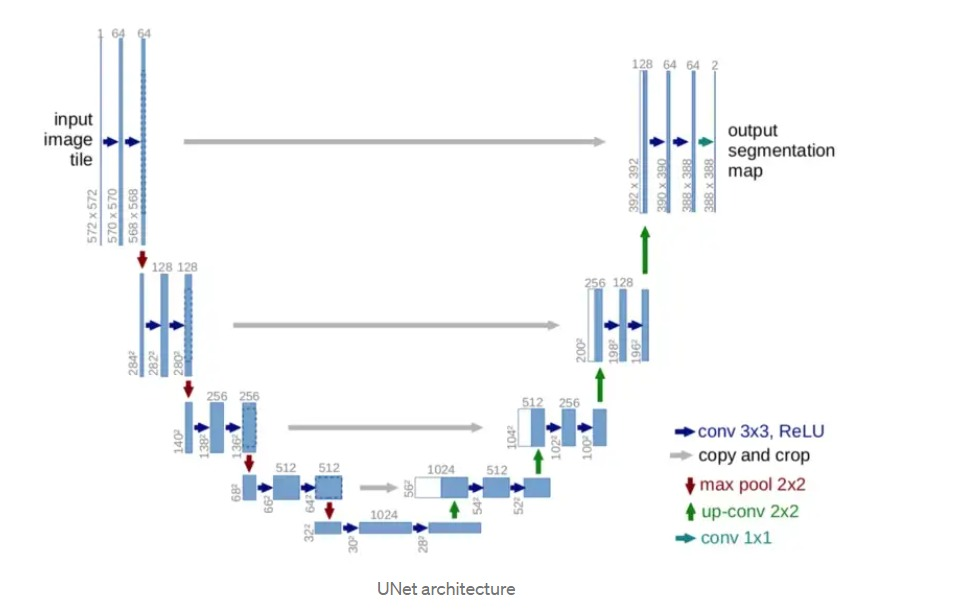

## Modelos planteados

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

In [7]:
# definición del coeficiente de Dice
def dice_coef(y_true, y_pred, smooth=1.0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# función de costo que combina binary crossentropy con Dice
def dice_coef_loss(y_true, y_pred):
    dice_term = 1 - dice_coef(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = dice_term * 0.5 + bce(y_true, y_pred)*0.5
    return loss

In [3]:
# definición de bloques para armar la arquitectura de UNet

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [8]:
# instanciación del modelo
model = UNet((128,128,1),start_ch=32,depth=5,batchnorm=False, residual = True,dropout=False)

In [9]:
# compilación
model.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [10]:
# instanciación del modelo
model_2 = UNet((64,64,1),start_ch=32,depth=5,batchnorm=False, residual = True,dropout=False)

In [11]:
# compilación
model_2.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

## Caso 1:
* 64 imagenes, con Transform= False y epocs= 20

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
epocs_1 = 20
verbose = 1
monitor='loss'
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
#model.fit(datagen, epochs = epocs, validation_data=datagen_val, callbacks=[checkpointer])

In [ ]:
history = model.fit(datagen_1_False, epochs = epocs_1, validation_data=datagen_val_1, callbacks=[checkpointer])

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.3533 - binary_crossentropy: 0.0569 - dice_coef: 0.3503 
Epoch 1: val_loss improved from inf to 0.35656, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 108s 71s/step - loss: 0.3533 - binary_crossentropy: 0.0569 - dice_coef: 0.3503 - val_loss: 0.3566 - val_binary_crossentropy: 0.0844 - val_dice_coef: 0.3713
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.3495 - binary_crossentropy: 0.0779 - dice_coef: 0.3789 
Epoch 2: val_loss did not improve from 0.35656
2/2 [==============================] - 96s 54s/step - loss: 0.3495 - binary_crossentropy: 0.0779 - dice_coef: 0.3789 - val_loss: 0.3955 - val_binary_crossentropy: 0.0585 - val_dice_coef: 0.2674
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: 0.3775 - binary_crossentropy: 0.0569 - dice_coef: 0.3019 
Epoch 3: val_loss improved from 0.35656 to 0.34753, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 113s 76s/step - loss: 0.3775 - binary_crossentropy: 0.0569 - dice_coef: 0.3019 - val_loss: 0.3475 - val_binary_crossentropy: 0.0666 - val_dice_coef: 0.3715
Epoch 4/20
2/2 [==============================] - ETA: 0s - loss: 0.3441 - binary_crossentropy: 0.0635 - dice_coef: 0.3754 
Epoch 4: val_loss improved from 0.34753 to 0.32253, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 122s 76s/step - loss: 0.3441 - binary_crossentropy: 0.0635 - dice_coef: 0.3754 - val_loss: 0.3225 - val_binary_crossentropy: 0.0480 - val_dice_coef: 0.4030
Epoch 5/20
2/2 [==============================] - ETA: 0s - loss: 0.3253 - binary_crossentropy: 0.0497 - dice_coef: 0.3991 
Epoch 5: val_loss did not improve from 0.32253
2/2 [==============================] - 94s 54s/step - loss: 0.3253 - binary_crossentropy: 0.0497 - dice_coef: 0.3991 - val_loss: 0.3327 - val_binary_crossentropy: 0.0551 - val_dice_coef: 0.3896
Epoch 6/20
2/2 [==============================] - ETA: 0s - loss: 0.3366 - binary_crossentropy: 0.0623 - dice_coef: 0.3891 
Epoch 6: val_loss improved from 0.32253 to 0.32136, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 103s 65s/step - loss: 0.3366 - binary_crossentropy: 0.0623 - dice_coef: 0.3891 - val_loss: 0.3214 - val_binary_crossentropy: 0.0582 - val_dice_coef: 0.4154
Epoch 7/20
2/2 [==============================] - ETA: 0s - loss: 0.3327 - binary_crossentropy: 0.0570 - dice_coef: 0.3917 
Epoch 7: val_loss improved from 0.32136 to 0.31370, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 101s 62s/step - loss: 0.3327 - binary_crossentropy: 0.0570 - dice_coef: 0.3917 - val_loss: 0.3137 - val_binary_crossentropy: 0.0478 - val_dice_coef: 0.4204
Epoch 8/20
2/2 [==============================] - ETA: 0s - loss: 0.3133 - binary_crossentropy: 0.0485 - dice_coef: 0.4220 
Epoch 8: val_loss did not improve from 0.31370
2/2 [==============================] - 95s 54s/step - loss: 0.3133 - binary_crossentropy: 0.0485 - dice_coef: 0.4220 - val_loss: 0.3192 - val_binary_crossentropy: 0.0511 - val_dice_coef: 0.4127
Epoch 9/20
2/2 [==============================] - ETA: 0s - loss: 0.3151 - binary_crossentropy: 0.0512 - dice_coef: 0.4210 
Epoch 9: val_loss improved from 0.31370 to 0.29257, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 115s 77s/step - loss: 0.3151 - binary_crossentropy: 0.0512 - dice_coef: 0.4210 - val_loss: 0.2926 - val_binary_crossentropy: 0.0485 - val_dice_coef: 0.4633
Epoch 10/20
2/2 [==============================] - ETA: 0s - loss: 0.2997 - binary_crossentropy: 0.0495 - dice_coef: 0.4500 
Epoch 10: val_loss improved from 0.29257 to 0.29133, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 102s 64s/step - loss: 0.2997 - binary_crossentropy: 0.0495 - dice_coef: 0.4500 - val_loss: 0.2913 - val_binary_crossentropy: 0.0528 - val_dice_coef: 0.4702
Epoch 11/20
2/2 [==============================] - ETA: 0s - loss: 0.2923 - binary_crossentropy: 0.0576 - dice_coef: 0.4730 
Epoch 11: val_loss improved from 0.29133 to 0.28377, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 107s 70s/step - loss: 0.2923 - binary_crossentropy: 0.0576 - dice_coef: 0.4730 - val_loss: 0.2838 - val_binary_crossentropy: 0.0511 - val_dice_coef: 0.4835
Epoch 12/20
2/2 [==============================] - ETA: 0s - loss: 0.2972 - binary_crossentropy: 0.0498 - dice_coef: 0.4555 
Epoch 12: val_loss improved from 0.28377 to 0.27351, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 103s 66s/step - loss: 0.2972 - binary_crossentropy: 0.0498 - dice_coef: 0.4555 - val_loss: 0.2735 - val_binary_crossentropy: 0.0442 - val_dice_coef: 0.4972
Epoch 13/20
2/2 [==============================] - ETA: 0s - loss: 0.2840 - binary_crossentropy: 0.0495 - dice_coef: 0.4815 
Epoch 13: val_loss did not improve from 0.27351
2/2 [==============================] - 100s 56s/step - loss: 0.2840 - binary_crossentropy: 0.0495 - dice_coef: 0.4815 - val_loss: 0.2837 - val_binary_crossentropy: 0.0484 - val_dice_coef: 0.4811
Epoch 14/20
2/2 [==============================] - ETA: 0s - loss: 0.2761 - binary_crossentropy: 0.0481 - dice_coef: 0.4959 
Epoch 14: val_loss did not improve from 0.27351
2/2 [==============================] - 99s 53s/step - loss: 0.2761 - binary_crossentropy: 0.0481 - dice_coef: 0.4959 - val_loss: 0.2819 - val_binary_crossentropy: 0.0513 - val_dice_coef: 0.4874
Epoch 15/20
2/2 [==============================] - ETA: 0s - loss: 0.2

2/2 [==============================] - 106s 69s/step - loss: 0.2732 - binary_crossentropy: 0.0505 - dice_coef: 0.5041 - val_loss: 0.2685 - val_binary_crossentropy: 0.0485 - val_dice_coef: 0.5116
Epoch 16/20
2/2 [==============================] - ETA: 0s - loss: 0.2772 - binary_crossentropy: 0.0473 - dice_coef: 0.4929 
Epoch 16: val_loss improved from 0.26845 to 0.26599, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 102s 62s/step - loss: 0.2772 - binary_crossentropy: 0.0473 - dice_coef: 0.4929 - val_loss: 0.2660 - val_binary_crossentropy: 0.0408 - val_dice_coef: 0.5088
Epoch 17/20
2/2 [==============================] - ETA: 0s - loss: 0.2762 - binary_crossentropy: 0.0402 - dice_coef: 0.4878 
Epoch 17: val_loss improved from 0.26599 to 0.25273, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False


2/2 [==============================] - 103s 61s/step - loss: 0.2762 - binary_crossentropy: 0.0402 - dice_coef: 0.4878 - val_loss: 0.2527 - val_binary_crossentropy: 0.0384 - val_dice_coef: 0.5330
Epoch 18/20
2/2 [==============================] - ETA: 0s - loss: 0.2551 - binary_crossentropy: 0.0405 - dice_coef: 0.5303 
Epoch 18: val_loss did not improve from 0.25273
2/2 [==============================] - 99s 53s/step - loss: 0.2551 - binary_crossentropy: 0.0405 - dice_coef: 0.5303 - val_loss: 0.2540 - val_binary_crossentropy: 0.0461 - val_dice_coef: 0.5381
Epoch 19/20
2/2 [==============================] - ETA: 0s - loss: 0.2621 - binary_crossentropy: 0.0491 - dice_coef: 0.5249 
Epoch 19: val_loss did not improve from 0.25273
2/2 [==============================] - 92s 55s/step - loss: 0.2621 - binary_crossentropy: 0.0491 - dice_coef: 0.5249 - val_loss: 0.2575 - val_binary_crossentropy: 0.0533 - val_dice_coef: 0.5384
Epoch 20/20
2/2 [==============================] - ETA: 0s - loss: 0.25

Se guarda el history del modelo:

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(model.history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde64_epochs20_Transform=False.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Se levantan los pesos del modelo:

In [ ]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=False'
model.load_weights(filepath)

Se levanta el history:

In [ ]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde64_epochs20_Transform=False.csv'
history = pd.read_csv(history_path)
history.head()

Unnamed: 0      loss  binary_crossentropy  dice_coef  val_loss  \
0           0  0.353290             0.056904   0.350323  0.356560   
1           1  0.349475             0.077891   0.378941  0.395535   
2           2  0.377512             0.056946   0.301922  0.347526   
3           3  0.344078             0.063542   0.375385  0.322529   
4           4  0.325313             0.049698   0.399072  0.332750   

   val_binary_crossentropy  val_dice_coef  
0                 0.084432       0.371311  
1                 0.058485       0.267415  
2                 0.066585       0.371532  
3                 0.048039       0.402980  
4                 0.055105       0.389605

Ploteamos el history:

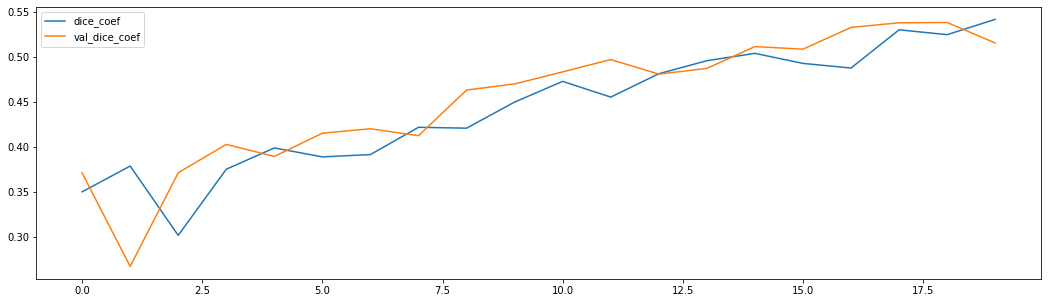

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

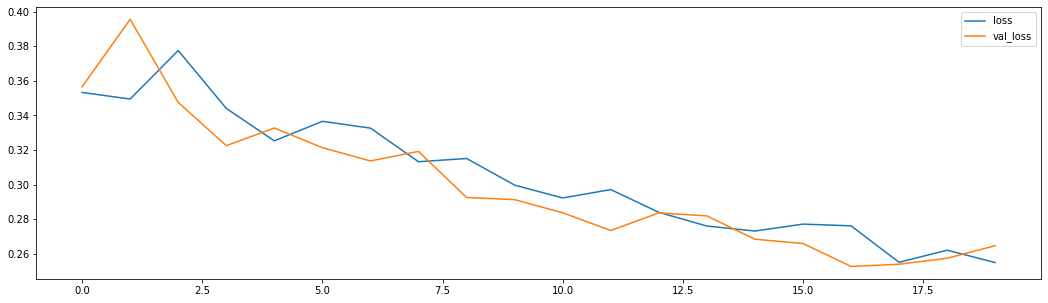

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();

## Caso 2:
* 64 imagenes, con Transform= True y epocs= 20

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
epocs_1 = 20
verbose = 1
monitor='loss'
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=True'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
#model.fit(datagen, epochs = epocs, validation_data=datagen_val, callbacks=[checkpointer])

In [ ]:
history_2 = model.fit(datagen_1_True, epochs = epocs_1, validation_data=datagen_val_1, callbacks=[checkpointer])

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.4385 - binary_crossentropy: 0.0876 - dice_coef: 0.2106 
Epoch 1: val_loss improved from inf to 0.26470, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=True


2/2 [==============================] - 112s 65s/step - loss: 0.4385 - binary_crossentropy: 0.0876 - dice_coef: 0.2106 - val_loss: 0.2647 - val_binary_crossentropy: 0.0339 - val_dice_coef: 0.5045
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.4761 - binary_crossentropy: 0.0782 - dice_coef: 0.1260 
Epoch 2: val_loss did not improve from 0.26470
2/2 [==============================] - 95s 56s/step - loss: 0.4761 - binary_crossentropy: 0.0782 - dice_coef: 0.1260 - val_loss: 0.3363 - val_binary_crossentropy: 0.0360 - val_dice_coef: 0.3633
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: 0.4896 - binary_crossentropy: 0.0606 - dice_coef: 0.0814 
Epoch 3: val_loss did not improve from 0.26470
2/2 [==============================] - 93s 53s/step - loss: 0.4896 - binary_crossentropy: 0.0606 - dice_coef: 0.0814 - val_loss: 0.3528 - val_binary_crossentropy: 0.0444 - val_dice_coef: 0.3388
Epoch 4/20
2/2 [==============================] - ETA: 0s - loss: 0.4267 - 

Se guarda el history del modelo:

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(model.history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde64_epochs20_Transform=True.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Se levantan los pesos del modelo:

In [ ]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs20_Transform=True'
model.load_weights(filepath)

Se levanta el history:

In [ ]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde64_epochs20_Transform=True.csv'
history = pd.read_csv(history_path)
history.head()

Unnamed: 0      loss  binary_crossentropy  dice_coef  val_loss  \
0           0  0.438518             0.087595   0.210558  0.264703   
1           1  0.476103             0.078211   0.126006  0.336324   
2           2  0.489612             0.060616   0.081392  0.352801   
3           3  0.426688             0.062781   0.209405  0.328146   
4           4  0.493542             0.091963   0.104880  0.350488   

   val_binary_crossentropy  val_dice_coef  
0                 0.033921       0.504515  
1                 0.035988       0.363341  
2                 0.044414       0.338812  
3                 0.060170       0.403878  
4                 0.064462       0.363485

Ploteamos el history:

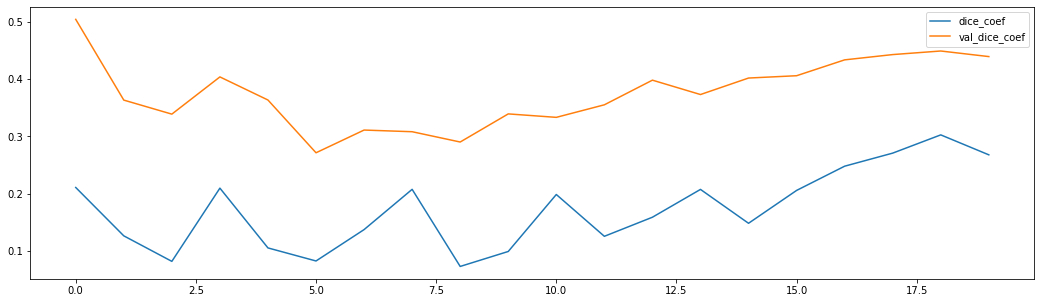

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

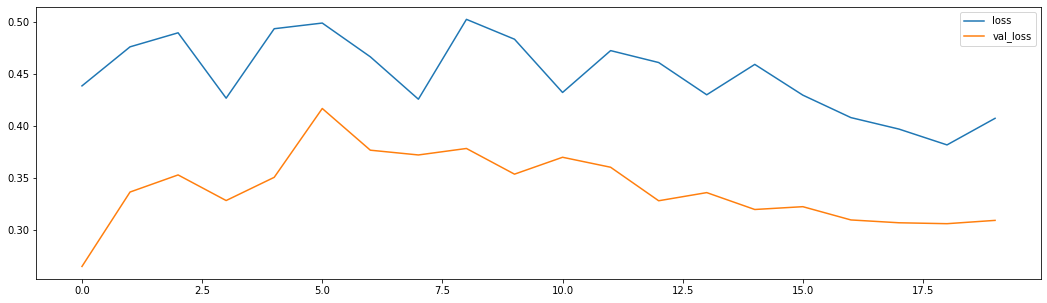

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();

## Caso 3:
* 64 imagenes, con Transform= False y epocs= 50


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
epocs = 50
verbose = 1
monitor='loss'
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
#model.fit(datagen, epochs = epocs, validation_data=datagen_val, callbacks=[checkpointer])

In [ ]:
history = model.fit(datagen_1_False, epochs = epocs, validation_data=datagen_val_1, callbacks=[checkpointer])

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.4077 - dice_coef: 0.0164 
Epoch 1: val_loss improved from inf to 13.42875, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 122s 69s/step - loss: 0.6956 - binary_crossentropy: 0.4077 - dice_coef: 0.0164 - val_loss: 13.4288 - val_binary_crossentropy: 25.8577 - val_dice_coef: 1.8552e-04
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 5.8462 - binary_crossentropy: 10.6931 - dice_coef: 6.5177e-04  
Epoch 2: val_loss improved from 13.42875 to 0.66695, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 100s 63s/step - loss: 5.8462 - binary_crossentropy: 10.6931 - dice_coef: 6.5177e-04 - val_loss: 0.6669 - val_binary_crossentropy: 0.3537 - val_dice_coef: 0.0198
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.6833 - binary_crossentropy: 0.3866 - dice_coef: 0.0200 
Epoch 3: val_loss did not improve from 0.66695
2/2 [==============================] - 94s 55s/step - loss: 0.6833 - binary_crossentropy: 0.3866 - dice_coef: 0.0200 - val_loss: 0.7042 - val_binary_crossentropy: 0.4287 - val_dice_coef: 0.0203
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 0.6988 - binary_crossentropy: 0.4178 - dice_coef: 0.0202 
Epoch 4: val_loss improved from 0.66695 to 0.66425, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 104s 62s/step - loss: 0.6988 - binary_crossentropy: 0.4178 - dice_coef: 0.0202 - val_loss: 0.6642 - val_binary_crossentropy: 0.3482 - val_dice_coef: 0.0197
Epoch 5/50
2/2 [==============================] - ETA: 0s - loss: 0.6323 - binary_crossentropy: 0.2826 - dice_coef: 0.0180 
Epoch 5: val_loss improved from 0.66425 to 0.55445, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 102s 64s/step - loss: 0.6323 - binary_crossentropy: 0.2826 - dice_coef: 0.0180 - val_loss: 0.5544 - val_binary_crossentropy: 0.1098 - val_dice_coef: 8.6000e-04
Epoch 6/50
2/2 [==============================] - ETA: 0s - loss: 0.5709 - binary_crossentropy: 0.1422 - dice_coef: 3.4480e-04 
Epoch 6: val_loss improved from 0.55445 to 0.55247, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 100s 63s/step - loss: 0.5709 - binary_crossentropy: 0.1422 - dice_coef: 3.4480e-04 - val_loss: 0.5525 - val_binary_crossentropy: 0.1054 - val_dice_coef: 4.5087e-04
Epoch 7/50
2/2 [==============================] - ETA: 0s - loss: 0.5457 - binary_crossentropy: 0.0941 - dice_coef: 0.0028     
Epoch 7: val_loss improved from 0.55247 to 0.53924, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 97s 61s/step - loss: 0.5457 - binary_crossentropy: 0.0941 - dice_coef: 0.0028 - val_loss: 0.5392 - val_binary_crossentropy: 0.0881 - val_dice_coef: 0.0097
Epoch 8/50
2/2 [==============================] - ETA: 0s - loss: 0.5385 - binary_crossentropy: 0.0871 - dice_coef: 0.0101 
Epoch 8: val_loss improved from 0.53924 to 0.53480, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 106s 69s/step - loss: 0.5385 - binary_crossentropy: 0.0871 - dice_coef: 0.0101 - val_loss: 0.5348 - val_binary_crossentropy: 0.0779 - val_dice_coef: 0.0083
Epoch 9/50
2/2 [==============================] - ETA: 0s - loss: 0.5345 - binary_crossentropy: 0.0761 - dice_coef: 0.0070 
Epoch 9: val_loss improved from 0.53480 to 0.53288, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 112s 73s/step - loss: 0.5345 - binary_crossentropy: 0.0761 - dice_coef: 0.0070 - val_loss: 0.5329 - val_binary_crossentropy: 0.0715 - val_dice_coef: 0.0058
Epoch 10/50
2/2 [==============================] - ETA: 0s - loss: 0.5312 - binary_crossentropy: 0.0698 - dice_coef: 0.0074 
Epoch 10: val_loss improved from 0.53288 to 0.52730, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 122s 77s/step - loss: 0.5312 - binary_crossentropy: 0.0698 - dice_coef: 0.0074 - val_loss: 0.5273 - val_binary_crossentropy: 0.0671 - val_dice_coef: 0.0125
Epoch 11/50
2/2 [==============================] - ETA: 0s - loss: 0.5264 - binary_crossentropy: 0.0665 - dice_coef: 0.0137 
Epoch 11: val_loss improved from 0.52730 to 0.52259, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 99s 62s/step - loss: 0.5264 - binary_crossentropy: 0.0665 - dice_coef: 0.0137 - val_loss: 0.5226 - val_binary_crossentropy: 0.0610 - val_dice_coef: 0.0158
Epoch 12/50
2/2 [==============================] - ETA: 0s - loss: 0.5212 - binary_crossentropy: 0.0599 - dice_coef: 0.0174 
Epoch 12: val_loss improved from 0.52259 to 0.51770, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 102s 63s/step - loss: 0.5212 - binary_crossentropy: 0.0599 - dice_coef: 0.0174 - val_loss: 0.5177 - val_binary_crossentropy: 0.0561 - val_dice_coef: 0.0207
Epoch 13/50
2/2 [==============================] - ETA: 0s - loss: 0.5175 - binary_crossentropy: 0.0580 - dice_coef: 0.0230 
Epoch 13: val_loss improved from 0.51770 to 0.51280, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 106s 69s/step - loss: 0.5175 - binary_crossentropy: 0.0580 - dice_coef: 0.0230 - val_loss: 0.5128 - val_binary_crossentropy: 0.0561 - val_dice_coef: 0.0305
Epoch 14/50
2/2 [==============================] - ETA: 0s - loss: 0.5167 - binary_crossentropy: 0.0579 - dice_coef: 0.0245 
Epoch 14: val_loss improved from 0.51280 to 0.51083, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 102s 62s/step - loss: 0.5167 - binary_crossentropy: 0.0579 - dice_coef: 0.0245 - val_loss: 0.5108 - val_binary_crossentropy: 0.0586 - val_dice_coef: 0.0370
Epoch 15/50
2/2 [==============================] - ETA: 0s - loss: 0.5112 - binary_crossentropy: 0.0599 - dice_coef: 0.0375 
Epoch 15: val_loss improved from 0.51083 to 0.50764, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 99s 61s/step - loss: 0.5112 - binary_crossentropy: 0.0599 - dice_coef: 0.0375 - val_loss: 0.5076 - val_binary_crossentropy: 0.0527 - val_dice_coef: 0.0374
Epoch 16/50
2/2 [==============================] - ETA: 0s - loss: 0.5073 - binary_crossentropy: 0.0531 - dice_coef: 0.0385 
Epoch 16: val_loss improved from 0.50764 to 0.50055, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 98s 61s/step - loss: 0.5073 - binary_crossentropy: 0.0531 - dice_coef: 0.0385 - val_loss: 0.5006 - val_binary_crossentropy: 0.0549 - val_dice_coef: 0.0538
Epoch 17/50
2/2 [==============================] - ETA: 0s - loss: 0.4972 - binary_crossentropy: 0.0541 - dice_coef: 0.0597 
Epoch 17: val_loss improved from 0.50055 to 0.49156, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 103s 64s/step - loss: 0.4972 - binary_crossentropy: 0.0541 - dice_coef: 0.0597 - val_loss: 0.4916 - val_binary_crossentropy: 0.0565 - val_dice_coef: 0.0734
Epoch 18/50
2/2 [==============================] - ETA: 0s - loss: 0.4916 - binary_crossentropy: 0.0576 - dice_coef: 0.0745 
Epoch 18: val_loss improved from 0.49156 to 0.48406, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 112s 71s/step - loss: 0.4916 - binary_crossentropy: 0.0576 - dice_coef: 0.0745 - val_loss: 0.4841 - val_binary_crossentropy: 0.0551 - val_dice_coef: 0.0870
Epoch 19/50
2/2 [==============================] - ETA: 0s - loss: 0.4846 - binary_crossentropy: 0.0578 - dice_coef: 0.0886 
Epoch 19: val_loss improved from 0.48406 to 0.47660, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 101s 62s/step - loss: 0.4846 - binary_crossentropy: 0.0578 - dice_coef: 0.0886 - val_loss: 0.4766 - val_binary_crossentropy: 0.0519 - val_dice_coef: 0.0987
Epoch 20/50
2/2 [==============================] - ETA: 0s - loss: 0.4758 - binary_crossentropy: 0.0513 - dice_coef: 0.0996 
Epoch 20: val_loss improved from 0.47660 to 0.46825, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 102s 63s/step - loss: 0.4758 - binary_crossentropy: 0.0513 - dice_coef: 0.0996 - val_loss: 0.4683 - val_binary_crossentropy: 0.0500 - val_dice_coef: 0.1135
Epoch 21/50
2/2 [==============================] - ETA: 0s - loss: 0.4758 - binary_crossentropy: 0.0576 - dice_coef: 0.1059 
Epoch 21: val_loss did not improve from 0.46825
2/2 [==============================] - 92s 53s/step - loss: 0.4758 - binary_crossentropy: 0.0576 - dice_coef: 0.1059 - val_loss: 0.4783 - val_binary_crossentropy: 0.0624 - val_dice_coef: 0.1057
Epoch 22/50
2/2 [==============================] - ETA: 0s - loss: 0.4828 - binary_crossentropy: 0.0656 - dice_coef: 0.0999 
Epoch 22: val_loss did not improve from 0.46825
2/2 [==============================] - 98s 59s/step - loss: 0.4828 - binary_crossentropy: 0.0656 - dice_coef: 0.0999 - val_loss: 0.4689 - val_binary_crossentropy: 0.0588 - val_dice_coef: 0.1210
Epoch 23/50
2/2 [==============================] - ETA: 0s - loss: 0.48

2/2 [==============================] - 109s 68s/step - loss: 0.4891 - binary_crossentropy: 0.0704 - dice_coef: 0.0921 - val_loss: 0.4601 - val_binary_crossentropy: 0.0519 - val_dice_coef: 0.1318
Epoch 24/50
2/2 [==============================] - ETA: 0s - loss: 0.4678 - binary_crossentropy: 0.0562 - dice_coef: 0.1206 
Epoch 24: val_loss did not improve from 0.46007
2/2 [==============================] - 101s 60s/step - loss: 0.4678 - binary_crossentropy: 0.0562 - dice_coef: 0.1206 - val_loss: 0.4747 - val_binary_crossentropy: 0.0615 - val_dice_coef: 0.1120
Epoch 25/50
2/2 [==============================] - ETA: 0s - loss: 0.4732 - binary_crossentropy: 0.0651 - dice_coef: 0.1187 
Epoch 25: val_loss did not improve from 0.46007
2/2 [==============================] - 93s 55s/step - loss: 0.4732 - binary_crossentropy: 0.0651 - dice_coef: 0.1187 - val_loss: 0.4624 - val_binary_crossentropy: 0.0652 - val_dice_coef: 0.1403
Epoch 26/50
2/2 [==============================] - ETA: 0s - loss: 0.4

2/2 [==============================] - 99s 62s/step - loss: 0.4622 - binary_crossentropy: 0.0572 - dice_coef: 0.1327 - val_loss: 0.4538 - val_binary_crossentropy: 0.0497 - val_dice_coef: 0.1421
Epoch 28/50
2/2 [==============================] - ETA: 0s - loss: 0.4498 - binary_crossentropy: 0.0495 - dice_coef: 0.1499 
Epoch 28: val_loss improved from 0.45379 to 0.44844, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 100s 61s/step - loss: 0.4498 - binary_crossentropy: 0.0495 - dice_coef: 0.1499 - val_loss: 0.4484 - val_binary_crossentropy: 0.0542 - val_dice_coef: 0.1574
Epoch 29/50
2/2 [==============================] - ETA: 0s - loss: 0.4478 - binary_crossentropy: 0.0561 - dice_coef: 0.1606 
Epoch 29: val_loss improved from 0.44844 to 0.44470, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 111s 64s/step - loss: 0.4478 - binary_crossentropy: 0.0561 - dice_coef: 0.1606 - val_loss: 0.4447 - val_binary_crossentropy: 0.0605 - val_dice_coef: 0.1711
Epoch 30/50
2/2 [==============================] - ETA: 0s - loss: 0.4391 - binary_crossentropy: 0.0581 - dice_coef: 0.1798 
Epoch 30: val_loss did not improve from 0.44470
2/2 [==============================] - 89s 53s/step - loss: 0.4391 - binary_crossentropy: 0.0581 - dice_coef: 0.1798 - val_loss: 0.4879 - val_binary_crossentropy: 0.0623 - val_dice_coef: 0.0865
Epoch 31/50
2/2 [==============================] - ETA: 0s - loss: 0.4715 - binary_crossentropy: 0.0637 - dice_coef: 0.1207 
Epoch 31: val_loss did not improve from 0.44470
2/2 [==============================] - 92s 55s/step - loss: 0.4715 - binary_crossentropy: 0.0637 - dice_coef: 0.1207 - val_loss: 0.4691 - val_binary_crossentropy: 0.0951 - val_dice_coef: 0.1570
Epoch 32/50
2/2 [==============================] - ETA: 0s - loss: 0.46

2/2 [==============================] - 98s 61s/step - loss: 0.4619 - binary_crossentropy: 0.0855 - dice_coef: 0.1617 - val_loss: 0.4402 - val_binary_crossentropy: 0.0606 - val_dice_coef: 0.1801
Epoch 33/50
2/2 [==============================] - ETA: 0s - loss: 0.4441 - binary_crossentropy: 0.0616 - dice_coef: 0.1733 
Epoch 33: val_loss did not improve from 0.44024
2/2 [==============================] - 96s 55s/step - loss: 0.4441 - binary_crossentropy: 0.0616 - dice_coef: 0.1733 - val_loss: 0.4410 - val_binary_crossentropy: 0.0625 - val_dice_coef: 0.1805
Epoch 34/50
2/2 [==============================] - ETA: 0s - loss: 0.4375 - binary_crossentropy: 0.0641 - dice_coef: 0.1892 
Epoch 34: val_loss did not improve from 0.44024
2/2 [==============================] - 89s 53s/step - loss: 0.4375 - binary_crossentropy: 0.0641 - dice_coef: 0.1892 - val_loss: 0.4411 - val_binary_crossentropy: 0.0687 - val_dice_coef: 0.1865
Epoch 35/50
2/2 [==============================] - ETA: 0s - loss: 0.441

2/2 [==============================] - 109s 63s/step - loss: 0.4412 - binary_crossentropy: 0.0694 - dice_coef: 0.1870 - val_loss: 0.4291 - val_binary_crossentropy: 0.0605 - val_dice_coef: 0.2024
Epoch 36/50
2/2 [==============================] - ETA: 0s - loss: 0.4307 - binary_crossentropy: 0.0592 - dice_coef: 0.1977 
Epoch 36: val_loss did not improve from 0.42907
2/2 [==============================] - 92s 53s/step - loss: 0.4307 - binary_crossentropy: 0.0592 - dice_coef: 0.1977 - val_loss: 0.4354 - val_binary_crossentropy: 0.0616 - val_dice_coef: 0.1908
Epoch 37/50
2/2 [==============================] - ETA: 0s - loss: 0.4322 - binary_crossentropy: 0.0605 - dice_coef: 0.1961 
Epoch 37: val_loss improved from 0.42907 to 0.41185, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 99s 62s/step - loss: 0.4322 - binary_crossentropy: 0.0605 - dice_coef: 0.1961 - val_loss: 0.4119 - val_binary_crossentropy: 0.0611 - val_dice_coef: 0.2374
Epoch 38/50
2/2 [==============================] - ETA: 0s - loss: 0.4133 - binary_crossentropy: 0.0656 - dice_coef: 0.2389 
Epoch 38: val_loss improved from 0.41185 to 0.40821, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 105s 66s/step - loss: 0.4133 - binary_crossentropy: 0.0656 - dice_coef: 0.2389 - val_loss: 0.4082 - val_binary_crossentropy: 0.0760 - val_dice_coef: 0.2596
Epoch 39/50
2/2 [==============================] - ETA: 0s - loss: 0.4068 - binary_crossentropy: 0.0782 - dice_coef: 0.2645 
Epoch 39: val_loss did not improve from 0.40821
2/2 [==============================] - 94s 56s/step - loss: 0.4068 - binary_crossentropy: 0.0782 - dice_coef: 0.2645 - val_loss: 0.4084 - val_binary_crossentropy: 0.0618 - val_dice_coef: 0.2450
Epoch 40/50
2/2 [==============================] - ETA: 0s - loss: 0.4114 - binary_crossentropy: 0.0620 - dice_coef: 0.2392 
Epoch 40: val_loss improved from 0.40821 to 0.40500, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 109s 71s/step - loss: 0.4114 - binary_crossentropy: 0.0620 - dice_coef: 0.2392 - val_loss: 0.4050 - val_binary_crossentropy: 0.0770 - val_dice_coef: 0.2670
Epoch 41/50
2/2 [==============================] - ETA: 0s - loss: 0.4073 - binary_crossentropy: 0.0765 - dice_coef: 0.2620 
Epoch 41: val_loss improved from 0.40500 to 0.38905, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 119s 75s/step - loss: 0.4073 - binary_crossentropy: 0.0765 - dice_coef: 0.2620 - val_loss: 0.3891 - val_binary_crossentropy: 0.0548 - val_dice_coef: 0.2767
Epoch 42/50
2/2 [==============================] - ETA: 0s - loss: 0.3844 - binary_crossentropy: 0.0561 - dice_coef: 0.2873 
Epoch 42: val_loss improved from 0.38905 to 0.38761, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 112s 66s/step - loss: 0.3844 - binary_crossentropy: 0.0561 - dice_coef: 0.2873 - val_loss: 0.3876 - val_binary_crossentropy: 0.0728 - val_dice_coef: 0.2975
Epoch 43/50
2/2 [==============================] - ETA: 0s - loss: 0.3919 - binary_crossentropy: 0.0824 - dice_coef: 0.2985 
Epoch 43: val_loss did not improve from 0.38761
2/2 [==============================] - 103s 53s/step - loss: 0.3919 - binary_crossentropy: 0.0824 - dice_coef: 0.2985 - val_loss: 0.4217 - val_binary_crossentropy: 0.0817 - val_dice_coef: 0.2383
Epoch 44/50
2/2 [==============================] - ETA: 0s - loss: 0.4037 - binary_crossentropy: 0.0786 - dice_coef: 0.2713 
Epoch 44: val_loss improved from 0.38761 to 0.38679, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 102s 62s/step - loss: 0.4037 - binary_crossentropy: 0.0786 - dice_coef: 0.2713 - val_loss: 0.3868 - val_binary_crossentropy: 0.0640 - val_dice_coef: 0.2904
Epoch 45/50
2/2 [==============================] - ETA: 0s - loss: 0.3904 - binary_crossentropy: 0.0593 - dice_coef: 0.2785 
Epoch 45: val_loss improved from 0.38679 to 0.37481, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 108s 68s/step - loss: 0.3904 - binary_crossentropy: 0.0593 - dice_coef: 0.2785 - val_loss: 0.3748 - val_binary_crossentropy: 0.0499 - val_dice_coef: 0.3003
Epoch 46/50
2/2 [==============================] - ETA: 0s - loss: 0.3761 - binary_crossentropy: 0.0551 - dice_coef: 0.3029 
Epoch 46: val_loss improved from 0.37481 to 0.36802, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 104s 64s/step - loss: 0.3761 - binary_crossentropy: 0.0551 - dice_coef: 0.3029 - val_loss: 0.3680 - val_binary_crossentropy: 0.0672 - val_dice_coef: 0.3311
Epoch 47/50
2/2 [==============================] - ETA: 0s - loss: 0.3714 - binary_crossentropy: 0.0705 - dice_coef: 0.3278 
Epoch 47: val_loss improved from 0.36802 to 0.36021, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 104s 63s/step - loss: 0.3714 - binary_crossentropy: 0.0705 - dice_coef: 0.3278 - val_loss: 0.3602 - val_binary_crossentropy: 0.0704 - val_dice_coef: 0.3499
Epoch 48/50
2/2 [==============================] - ETA: 0s - loss: 0.3549 - binary_crossentropy: 0.0651 - dice_coef: 0.3554 
Epoch 48: val_loss improved from 0.36021 to 0.33969, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 104s 64s/step - loss: 0.3549 - binary_crossentropy: 0.0651 - dice_coef: 0.3554 - val_loss: 0.3397 - val_binary_crossentropy: 0.0519 - val_dice_coef: 0.3726
Epoch 49/50
2/2 [==============================] - ETA: 0s - loss: 0.3436 - binary_crossentropy: 0.0534 - dice_coef: 0.3662 
Epoch 49: val_loss improved from 0.33969 to 0.32732, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False


2/2 [==============================] - 101s 62s/step - loss: 0.3436 - binary_crossentropy: 0.0534 - dice_coef: 0.3662 - val_loss: 0.3273 - val_binary_crossentropy: 0.0549 - val_dice_coef: 0.4003
Epoch 50/50
2/2 [==============================] - ETA: 0s - loss: 0.3531 - binary_crossentropy: 0.0552 - dice_coef: 0.3489 
Epoch 50: val_loss did not improve from 0.32732
2/2 [==============================] - 99s 60s/step - loss: 0.3531 - binary_crossentropy: 0.0552 - dice_coef: 0.3489 - val_loss: 0.3748 - val_binary_crossentropy: 0.0867 - val_dice_coef: 0.3370


Se guarda el history del modelo:

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(model.history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde64_epochs50_Transform=False.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Se levantan los pesos del modelo:

In [ ]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=False'
model.load_weights(filepath)

Se levanta el history:

In [ ]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde64_epochs50_Transform=False.csv'
history = pd.read_csv(history_path)
history.head()

Unnamed: 0      loss  binary_crossentropy  dice_coef   val_loss  \
0           0  0.695626             0.407663   0.016412  13.428754   
1           1  5.846229            10.693110   0.000652   0.666949   
2           2  0.683285             0.386586   0.020016   0.704212   
3           3  0.698760             0.417762   0.020242   0.664248   
4           4  0.632281             0.282580   0.018017   0.554446   

   val_binary_crossentropy  val_dice_coef  
0                25.857693       0.000186  
1                 0.353747       0.019850  
2                 0.428707       0.020282  
3                 0.348238       0.019743  
4                 0.109752       0.000860

Ploteamos el history:

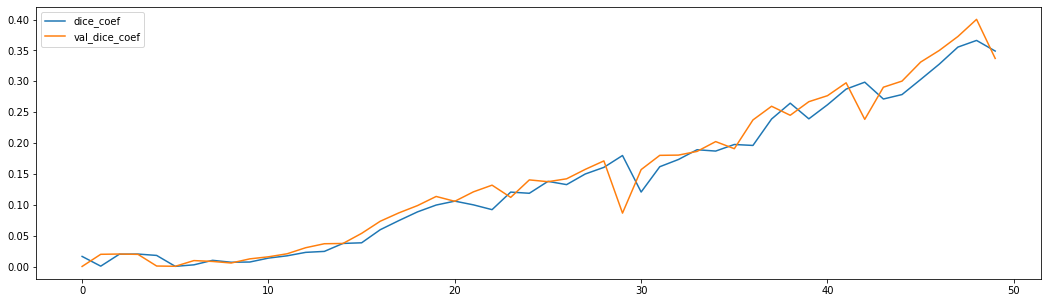

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

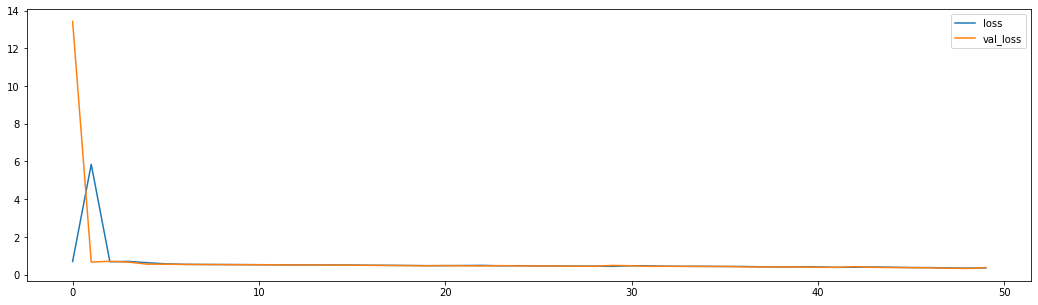

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();

## Caso 4:
* 64 imagenes, con Transform= True y epocs= 50

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
epocs = 50
verbose = 1
monitor='loss'
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=True'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
#model.fit(datagen, epochs = epocs, validation_data=datagen_val, callbacks=[checkpointer])

In [ ]:
history = model.fit(datagen_1_True, epochs = epocs, validation_data=datagen_val_1, callbacks=[checkpointer])

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.4416 - binary_crossentropy: 0.0708 - dice_coef: 0.1876 
Epoch 1: val_loss improved from inf to 0.31961, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=True


2/2 [==============================] - 109s 69s/step - loss: 0.4416 - binary_crossentropy: 0.0708 - dice_coef: 0.1876 - val_loss: 0.3196 - val_binary_crossentropy: 0.0345 - val_dice_coef: 0.3953
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.3975 - binary_crossentropy: 0.0532 - dice_coef: 0.2582 
Epoch 2: val_loss improved from 0.31961 to 0.28578, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=True


2/2 [==============================] - 109s 64s/step - loss: 0.3975 - binary_crossentropy: 0.0532 - dice_coef: 0.2582 - val_loss: 0.2858 - val_binary_crossentropy: 0.0478 - val_dice_coef: 0.4763
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.4618 - binary_crossentropy: 0.0967 - dice_coef: 0.1731 
Epoch 3: val_loss did not improve from 0.28578
2/2 [==============================] - 94s 54s/step - loss: 0.4618 - binary_crossentropy: 0.0967 - dice_coef: 0.1731 - val_loss: 0.3163 - val_binary_crossentropy: 0.0674 - val_dice_coef: 0.4348
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 0.5077 - binary_crossentropy: 0.0968 - dice_coef: 0.0814 
Epoch 4: val_loss did not improve from 0.28578
2/2 [==============================] - 101s 55s/step - loss: 0.5077 - binary_crossentropy: 0.0968 - dice_coef: 0.0814 - val_loss: 0.3195 - val_binary_crossentropy: 0.0452 - val_dice_coef: 0.4062
Epoch 5/50
2/2 [==============================] - ETA: 0s - loss: 0.4549 -

2/2 [==============================] - 100s 63s/step - loss: 0.4343 - binary_crossentropy: 0.0521 - dice_coef: 0.1835 - val_loss: 0.2847 - val_binary_crossentropy: 0.0480 - val_dice_coef: 0.4787
Epoch 7/50
2/2 [==============================] - ETA: 0s - loss: 0.4440 - binary_crossentropy: 0.0819 - dice_coef: 0.1939 
Epoch 7: val_loss did not improve from 0.28466
2/2 [==============================] - 93s 55s/step - loss: 0.4440 - binary_crossentropy: 0.0819 - dice_coef: 0.1939 - val_loss: 0.3178 - val_binary_crossentropy: 0.0648 - val_dice_coef: 0.4292
Epoch 8/50
2/2 [==============================] - ETA: 0s - loss: 0.4294 - binary_crossentropy: 0.0838 - dice_coef: 0.2251 
Epoch 8: val_loss did not improve from 0.28466
2/2 [==============================] - 91s 54s/step - loss: 0.4294 - binary_crossentropy: 0.0838 - dice_coef: 0.2251 - val_loss: 0.2887 - val_binary_crossentropy: 0.0422 - val_dice_coef: 0.4648
Epoch 9/50
2/2 [==============================] - ETA: 0s - loss: 0.3971 - 

2/2 [==============================] - 102s 63s/step - loss: 0.3971 - binary_crossentropy: 0.0576 - dice_coef: 0.2635 - val_loss: 0.2772 - val_binary_crossentropy: 0.0365 - val_dice_coef: 0.4821
Epoch 10/50
2/2 [==============================] - ETA: 0s - loss: 0.4378 - binary_crossentropy: 0.0629 - dice_coef: 0.1874 
Epoch 10: val_loss did not improve from 0.27716
2/2 [==============================] - 95s 56s/step - loss: 0.4378 - binary_crossentropy: 0.0629 - dice_coef: 0.1874 - val_loss: 0.2958 - val_binary_crossentropy: 0.0453 - val_dice_coef: 0.4536
Epoch 11/50
2/2 [==============================] - ETA: 0s - loss: 0.4520 - binary_crossentropy: 0.0677 - dice_coef: 0.1638 
Epoch 11: val_loss did not improve from 0.27716
2/2 [==============================] - 91s 53s/step - loss: 0.4520 - binary_crossentropy: 0.0677 - dice_coef: 0.1638 - val_loss: 0.3191 - val_binary_crossentropy: 0.0587 - val_dice_coef: 0.4205
Epoch 12/50
2/2 [==============================] - ETA: 0s - loss: 0.40

2/2 [==============================] - 125s 87s/step - loss: 0.4171 - binary_crossentropy: 0.0638 - dice_coef: 0.2296 - val_loss: 0.2693 - val_binary_crossentropy: 0.0377 - val_dice_coef: 0.4992
Epoch 30/50
2/2 [==============================] - ETA: 0s - loss: 0.3944 - binary_crossentropy: 0.0580 - dice_coef: 0.2692 
Epoch 30: val_loss did not improve from 0.26926
2/2 [==============================] - 92s 53s/step - loss: 0.3944 - binary_crossentropy: 0.0580 - dice_coef: 0.2692 - val_loss: 0.2796 - val_binary_crossentropy: 0.0425 - val_dice_coef: 0.4834
Epoch 31/50
2/2 [==============================] - ETA: 0s - loss: 0.4209 - binary_crossentropy: 0.0658 - dice_coef: 0.2240 
Epoch 31: val_loss did not improve from 0.26926
2/2 [==============================] - 91s 54s/step - loss: 0.4209 - binary_crossentropy: 0.0658 - dice_coef: 0.2240 - val_loss: 0.2839 - val_binary_crossentropy: 0.0469 - val_dice_coef: 0.4790
Epoch 32/50
2/2 [==============================] - ETA: 0s - loss: 0.35

2/2 [==============================] - 108s 71s/step - loss: 0.3677 - binary_crossentropy: 0.0717 - dice_coef: 0.3362 - val_loss: 0.2615 - val_binary_crossentropy: 0.0470 - val_dice_coef: 0.5239
Epoch 34/50
2/2 [==============================] - ETA: 0s - loss: 0.4066 - binary_crossentropy: 0.0786 - dice_coef: 0.2654 
Epoch 34: val_loss did not improve from 0.26154
2/2 [==============================] - 92s 54s/step - loss: 0.4066 - binary_crossentropy: 0.0786 - dice_coef: 0.2654 - val_loss: 0.2868 - val_binary_crossentropy: 0.0494 - val_dice_coef: 0.4757
Epoch 35/50
2/2 [==============================] - ETA: 0s - loss: 0.3667 - binary_crossentropy: 0.0569 - dice_coef: 0.3236 
Epoch 35: val_loss improved from 0.26154 to 0.25615, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=True


2/2 [==============================] - 105s 64s/step - loss: 0.3667 - binary_crossentropy: 0.0569 - dice_coef: 0.3236 - val_loss: 0.2561 - val_binary_crossentropy: 0.0352 - val_dice_coef: 0.5229
Epoch 36/50
2/2 [==============================] - ETA: 0s - loss: 0.3831 - binary_crossentropy: 0.0606 - dice_coef: 0.2943 
Epoch 36: val_loss did not improve from 0.25615
2/2 [==============================] - 95s 56s/step - loss: 0.3831 - binary_crossentropy: 0.0606 - dice_coef: 0.2943 - val_loss: 0.2684 - val_binary_crossentropy: 0.0521 - val_dice_coef: 0.5153
Epoch 37/50
2/2 [==============================] - ETA: 0s - loss: 0.3373 - binary_crossentropy: 0.0674 - dice_coef: 0.3929 
Epoch 37: val_loss improved from 0.25615 to 0.24664, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=True


2/2 [==============================] - 102s 65s/step - loss: 0.3373 - binary_crossentropy: 0.0674 - dice_coef: 0.3929 - val_loss: 0.2466 - val_binary_crossentropy: 0.0456 - val_dice_coef: 0.5523
Epoch 38/50
2/2 [==============================] - ETA: 0s - loss: 0.3379 - binary_crossentropy: 0.0677 - dice_coef: 0.3919 
Epoch 38: val_loss did not improve from 0.24664
2/2 [==============================] - 99s 57s/step - loss: 0.3379 - binary_crossentropy: 0.0677 - dice_coef: 0.3919 - val_loss: 0.2469 - val_binary_crossentropy: 0.0431 - val_dice_coef: 0.5494
Epoch 39/50
2/2 [==============================] - ETA: 0s - loss: 0.3690 - binary_crossentropy: 0.0625 - dice_coef: 0.3244 
Epoch 39: val_loss did not improve from 0.24664
2/2 [==============================] - 91s 54s/step - loss: 0.3690 - binary_crossentropy: 0.0625 - dice_coef: 0.3244 - val_loss: 0.2573 - val_binary_crossentropy: 0.0449 - val_dice_coef: 0.5303
Epoch 40/50
2/2 [==============================] - ETA: 0s - loss: 0.35

2/2 [==============================] - 103s 63s/step - loss: 0.3568 - binary_crossentropy: 0.0585 - dice_coef: 0.3449 - val_loss: 0.2442 - val_binary_crossentropy: 0.0432 - val_dice_coef: 0.5547
Epoch 41/50
2/2 [==============================] - ETA: 0s - loss: 0.3155 - binary_crossentropy: 0.0528 - dice_coef: 0.4217 
Epoch 41: val_loss improved from 0.24425 to 0.23785, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=True


2/2 [==============================] - 102s 63s/step - loss: 0.3155 - binary_crossentropy: 0.0528 - dice_coef: 0.4217 - val_loss: 0.2378 - val_binary_crossentropy: 0.0460 - val_dice_coef: 0.5704
Epoch 42/50
2/2 [==============================] - ETA: 0s - loss: 0.2911 - binary_crossentropy: 0.0560 - dice_coef: 0.4739 
Epoch 42: val_loss improved from 0.23785 to 0.22506, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=True


2/2 [==============================] - 104s 64s/step - loss: 0.2911 - binary_crossentropy: 0.0560 - dice_coef: 0.4739 - val_loss: 0.2251 - val_binary_crossentropy: 0.0415 - val_dice_coef: 0.5913
Epoch 43/50
2/2 [==============================] - ETA: 0s - loss: 0.3469 - binary_crossentropy: 0.0592 - dice_coef: 0.3653 
Epoch 43: val_loss did not improve from 0.22506
2/2 [==============================] - 94s 55s/step - loss: 0.3469 - binary_crossentropy: 0.0592 - dice_coef: 0.3653 - val_loss: 0.2557 - val_binary_crossentropy: 0.0449 - val_dice_coef: 0.5335
Epoch 44/50
2/2 [==============================] - ETA: 0s - loss: 0.3493 - binary_crossentropy: 0.0580 - dice_coef: 0.3595 
Epoch 44: val_loss did not improve from 0.22506
2/2 [==============================] - 93s 54s/step - loss: 0.3493 - binary_crossentropy: 0.0580 - dice_coef: 0.3595 - val_loss: 0.2414 - val_binary_crossentropy: 0.0441 - val_dice_coef: 0.5613
Epoch 45/50
2/2 [==============================] - ETA: 0s - loss: 0.37

Se guarda el history del modelo:

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(model.history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde64_epochs50_Transform=True.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Se levantan los pesos del modelo:

In [ ]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde64_epochs50_Transform=True'
model.load_weights(filepath)

Se levanta el history:

In [ ]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde64_epochs50_Transform=True.csv'
history = pd.read_csv(history_path)
history.head()

Unnamed: 0      loss  binary_crossentropy  dice_coef  val_loss  \
0           0  0.441589             0.070769   0.187591  0.319608   
1           1  0.397506             0.053206   0.258195  0.285782   
2           2  0.461786             0.096705   0.173133  0.316327   
3           3  0.507727             0.096829   0.081375  0.319513   
4           4  0.454880             0.055596   0.145837  0.324327   

   val_binary_crossentropy  val_dice_coef  
0                 0.034475       0.395259  
1                 0.047846       0.476282  
2                 0.067416       0.434763  
3                 0.045234       0.406208  
4                 0.033353       0.384699

Ploteamos el history:

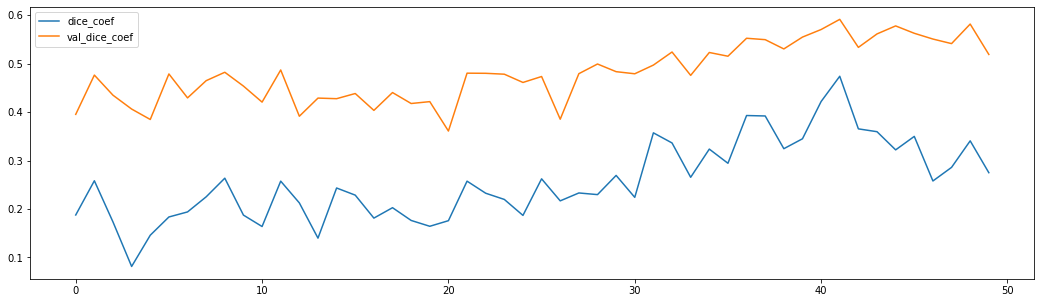

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

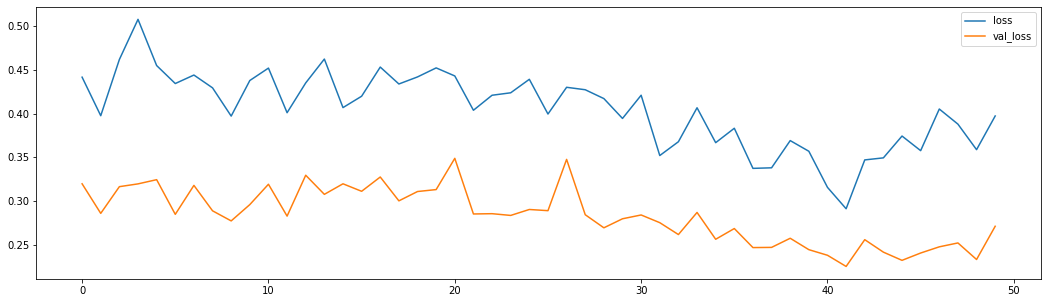

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();

------------------------------------------------------------------------

## Caso 5:
* 2000 imagenes, con Transform= False y epocs= 20

Para estos casos, se corrio en srcips separados para agilizar el tiempo y se importo directamente el history y los pesos del modelo. Ademas se uso (64,64) de resolucion en vez de (128,128) tambien para agilizar el fiteado. Cabe aclarar que anteriormente se hizo de prueba ver el mismo caso con 128 y con 64 y no habia cambios significativos en los resultados.

Se levantan los pesos del modelo:

In [ ]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs20_Transform=False_reshape'
model_2.load_weights(filepath)

Se levanta el history:

In [ ]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde2000_epochs20_Transform=False.csv'
history = pd.read_csv(history_path)
history.head()

Unnamed: 0      loss  binary_crossentropy  dice_coef  val_loss  \
0           0  0.659959             0.335021   0.015103  0.517911   
1           1  0.492788             0.072240   0.086664  0.479190   
2           2  0.469945             0.082745   0.142854  0.457487   
3           3  0.452593             0.082995   0.177809  0.451496   
4           4  0.436674             0.083270   0.209922  0.416991   

   val_binary_crossentropy  val_dice_coef  
0                 0.072774       0.036951  
1                 0.076817       0.118436  
2                 0.075882       0.160908  
3                 0.090076       0.187084  
4                 0.084433       0.250450

Ploteamos el history:

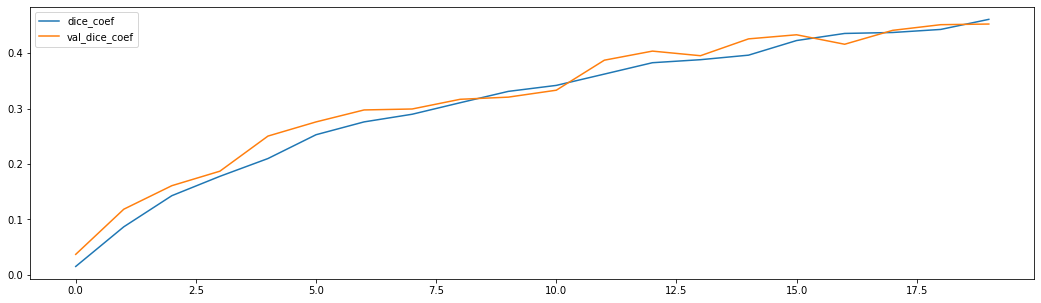

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

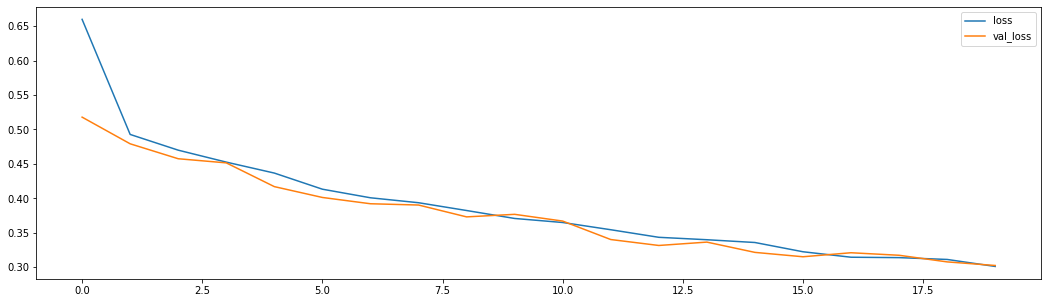

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();

## Caso 6:
* 2000 imagenes, con Transform= True y epocs= 20

Se levantan los pesos del modelo:

In [ ]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs20_Transform=True'
model_2.load_weights(filepath)

Se levanta el history:

In [ ]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde2000_epochs20_Transform=True.csv'
history = pd.read_csv(history_path)
history.head()

Unnamed: 0      loss  binary_crossentropy  dice_coef  val_loss  \
0           0  0.638578             0.292096   0.014939  0.523216   
1           1  0.516430             0.070609   0.037749  0.504383   
2           2  0.508591             0.073198   0.056016  0.497345   
3           3  0.503804             0.077394   0.069786  0.489996   
4           4  0.496959             0.079563   0.085646  0.483065   

   val_binary_crossentropy  val_dice_coef  
0                 0.072722       0.026291  
1                 0.070577       0.061811  
2                 0.067755       0.073065  
3                 0.079792       0.099801  
4                 0.069391       0.103261

Ploteamos el history:

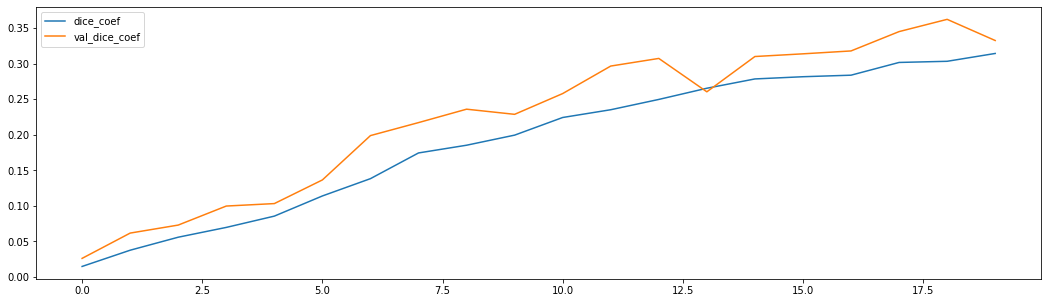

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

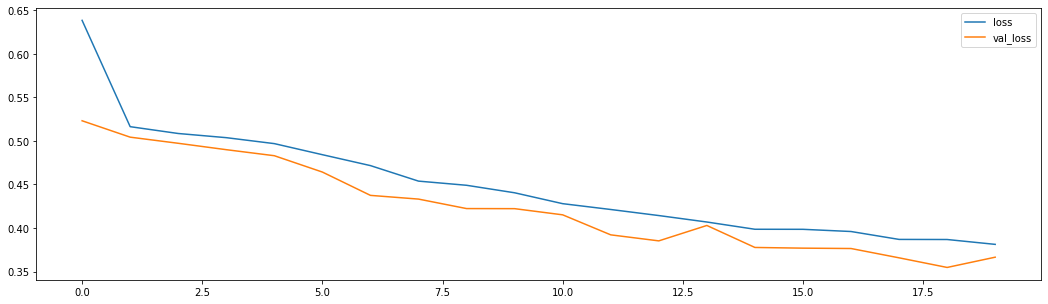

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();

## Caso 7:
* 2000 imagenes, con Transform= False y epocs= 50

Se levantan los pesos del modelo:

In [12]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False'
model_2.load_weights(filepath)

Se levanta el history:

In [16]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde2000_epochs50_Transform=False.csv'
history = pd.read_csv(history_path)
history.head()

Unnamed: 0      loss  binary_crossentropy  dice_coef  val_loss  \
0           0  0.624059             0.267329   0.019210  0.514994   
1           1  0.490787             0.078024   0.096451  0.478228   
2           2  0.467372             0.084917   0.150173  0.456789   
3           3  0.456658             0.085073   0.171757  0.442216   
4           4  0.433961             0.082313   0.214391  0.425825   

   val_binary_crossentropy  val_dice_coef  
0                 0.069274       0.039287  
1                 0.090665       0.134209  
2                 0.079203       0.165624  
3                 0.073527       0.189095  
4                 0.085520       0.233871

Ploteamos el history:

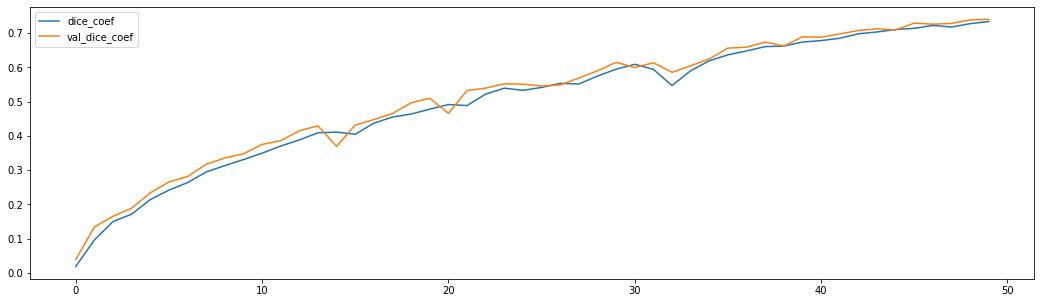

In [17]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

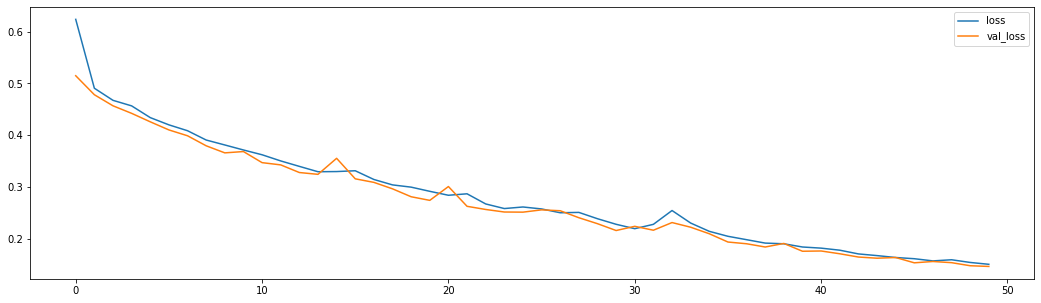

In [18]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();

## Caso 8:
* 2000 imagenes, con Transform= True y epocs= 50

Se levantan los pesos del modelo:

In [ ]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True'
model_2.load_weights(filepath)

Se levanta el history:

In [ ]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde2000_epochs50_Transform=True.csv'
history = pd.read_csv(history_path)
history.head()

Unnamed: 0      loss  binary_crossentropy  dice_coef  val_loss  \
0           0  0.595794             0.208990   0.017403  0.518754   
1           1  0.512126             0.074971   0.050719  0.504843   
2           2  0.505089             0.077598   0.067420  0.489097   
3           3  0.491961             0.082303   0.098381  0.475499   
4           4  0.477402             0.083667   0.128862  0.448595   

   val_binary_crossentropy  val_dice_coef  
0                 0.076056       0.038547  
1                 0.072925       0.063238  
2                 0.085948       0.107754  
3                 0.087404       0.136405  
4                 0.085747       0.188558

Ploteamos el history:

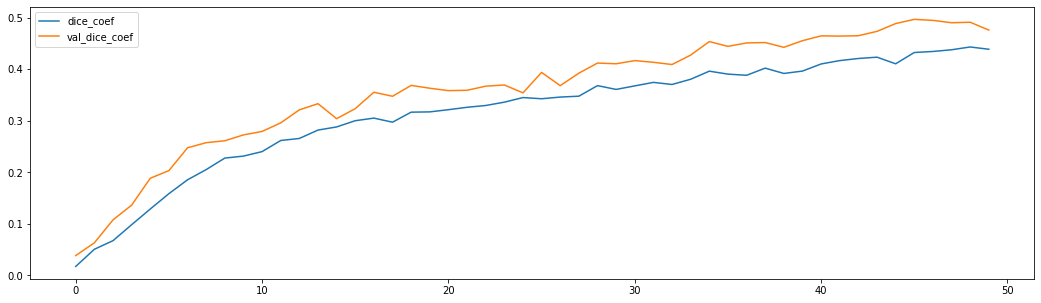

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

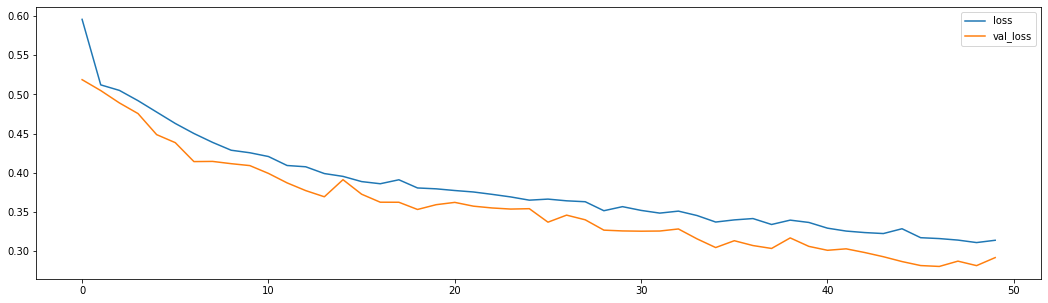

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();



#Predicciones

##Generar data

In [19]:
path_test = "/content/drive/Shareddrives/Redes de Piluchina/TP 3/dataset/siim-acr-pneumothorax/"

* Dataset 64

In [23]:
datagen_test_1 = DataGenerator(
    path_test,
    "png_image/img/",
    "png_masks/img/",
    transform = False,
    shuffle= False,
    batch_size = 32,
    train = False, 
)

In [ ]:
datagen_test_1[0][0].shape

(32, 128, 128, 1)

* Dataset 2000

In [24]:
datagen_test_2 = DataGenerator_2(
    path_test,
    "png_image/img/",
    "png_masks/img/",
    transform = False,
    shuffle= False,
    batch_size = 64,
    train = False, 
)

In [ ]:
datagen_test_2[0][0].shape

(64, 64, 64, 1)

##Caso 1

* 64 imagenes, con Transform= False y epocs= 20

In [ ]:
pred_test = model.predict(datagen_test_1)

9/9 [==============================] - 82s 9s/step


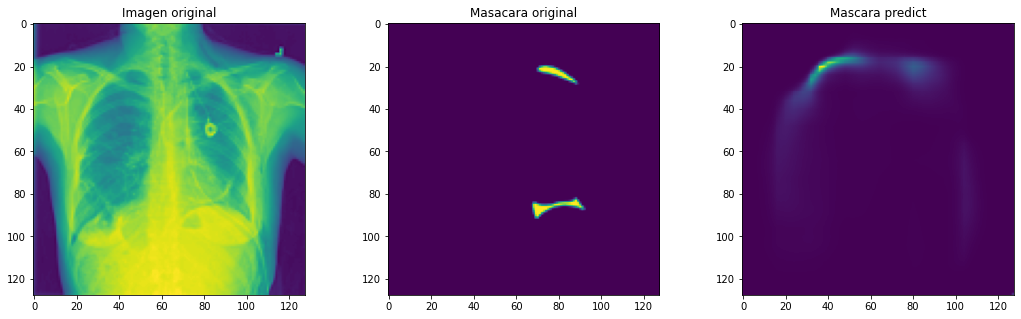

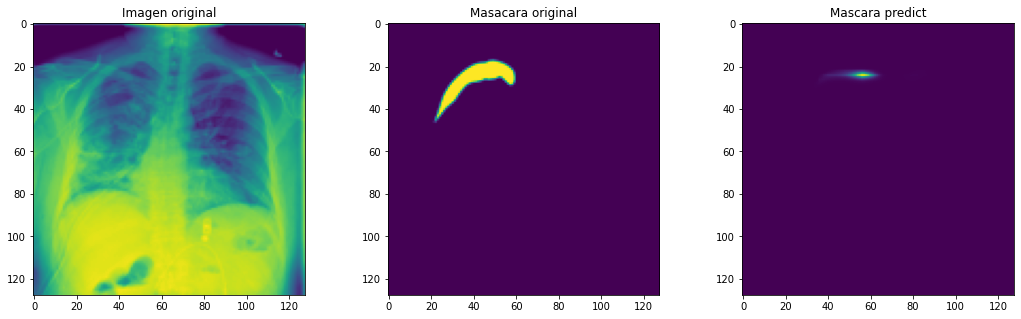

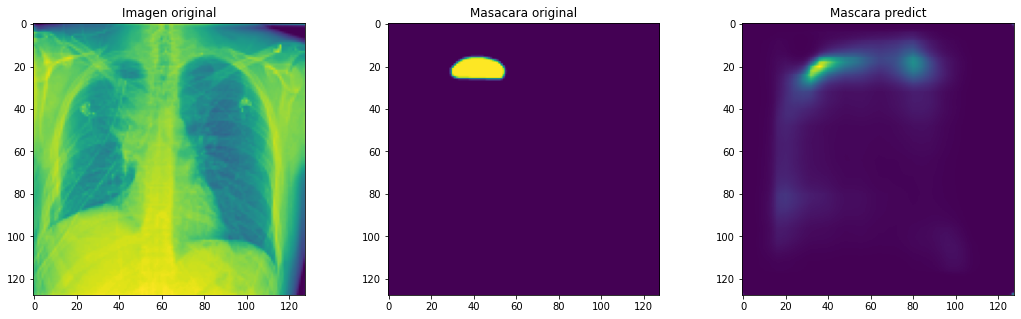

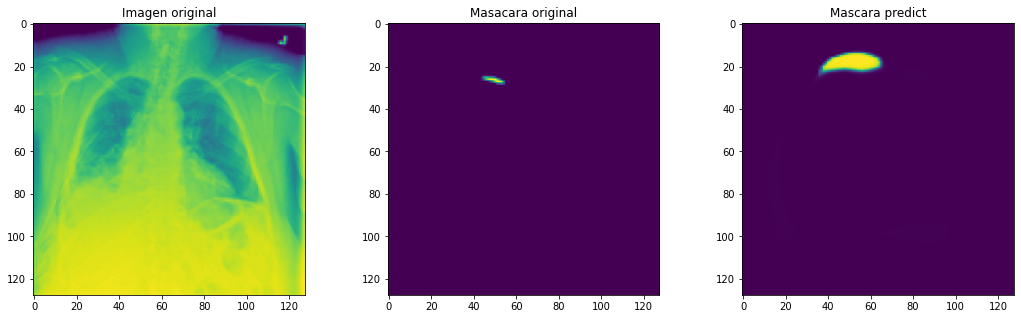

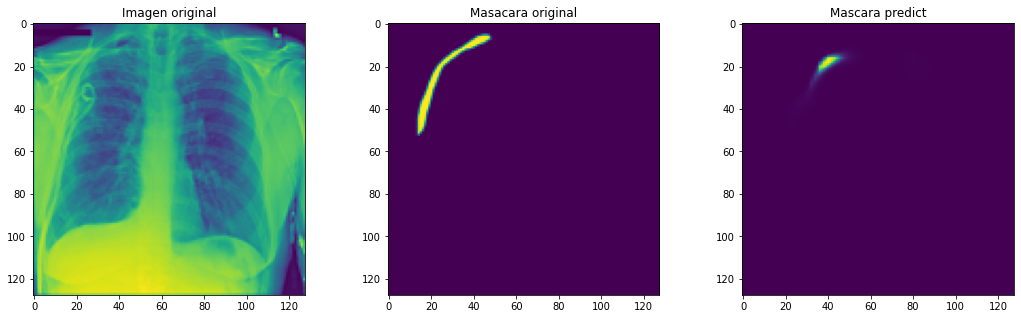

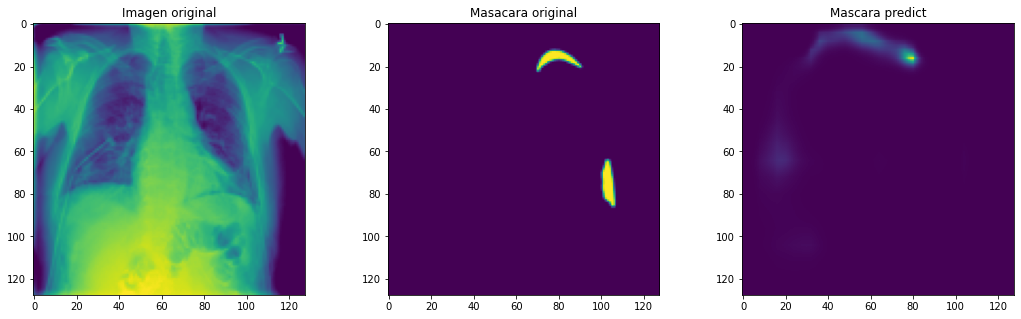

In [ ]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_1[0][0][idx].reshape(128,128))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_1[0][1][idx].reshape(128,128))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(128,128))
  ax3.set_title("Mascara predict")
  plt.show();

##Caso 2

* 64 imagenes, con Transform= True y epocs= 20

In [ ]:
pred_test = model.predict(datagen_test_1)

9/9 [==============================] - 87s 10s/step


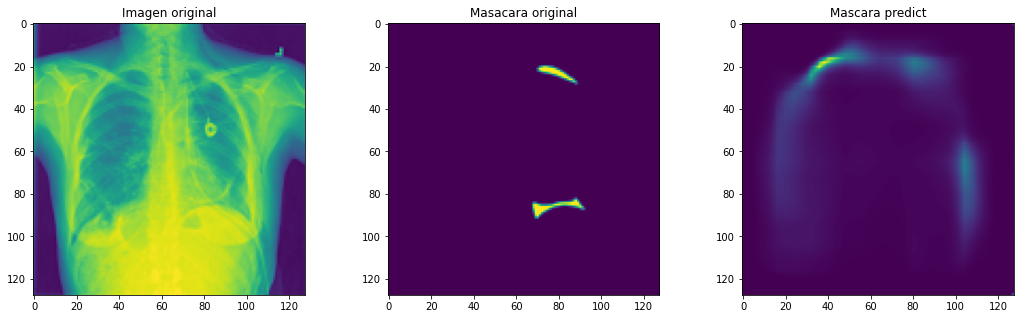

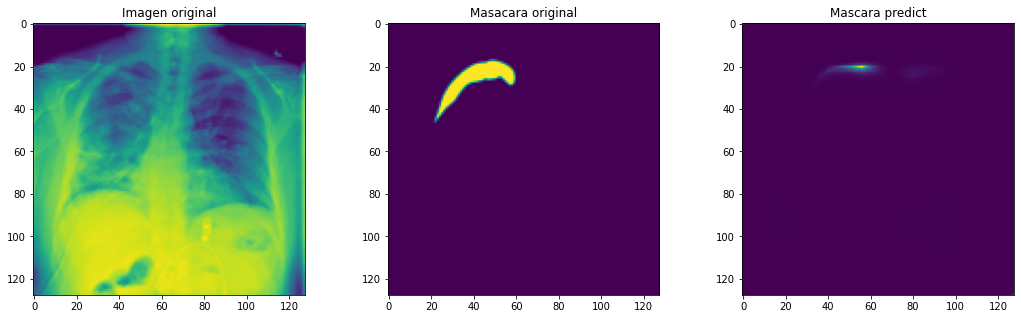

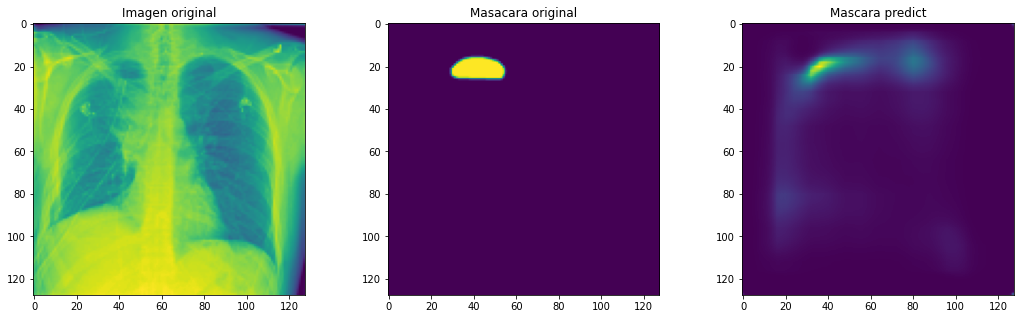

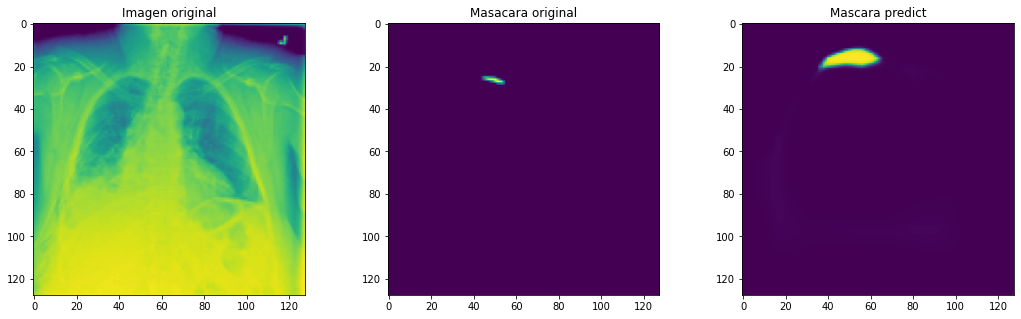

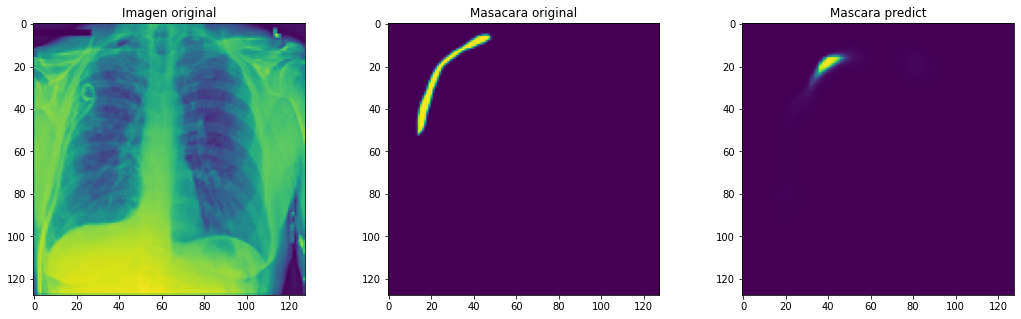

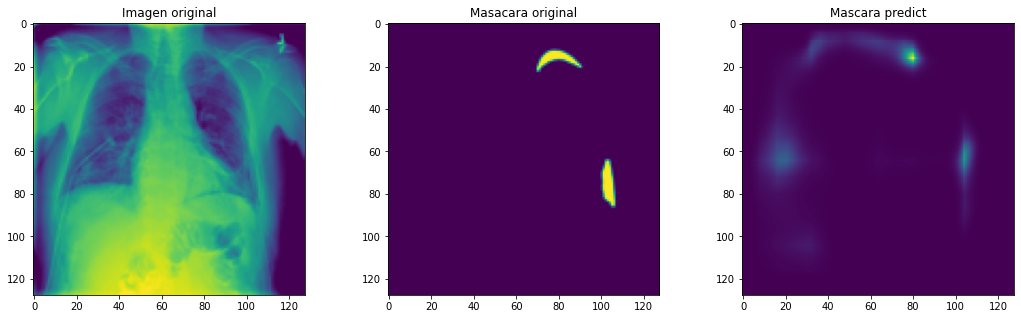

In [ ]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_1[0][0][idx].reshape(128,128))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_1[0][1][idx].reshape(128,128))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(128,128))
  ax3.set_title("Mascara predict")
  plt.show();

##Caso 3

* 64 imagenes, con Transform= False y epocs= 50

In [ ]:
pred_test = model.predict(datagen_test_1)

9/9 [==============================] - 177s 21s/step


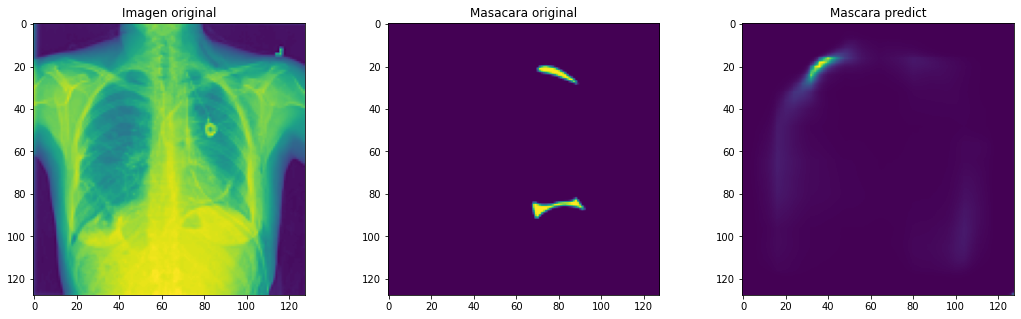

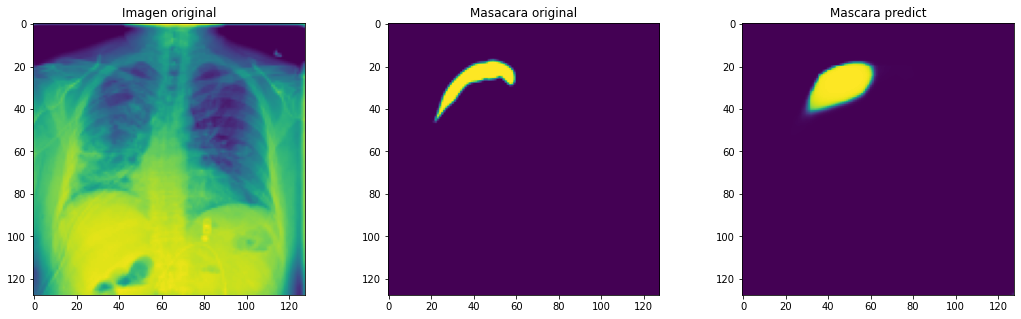

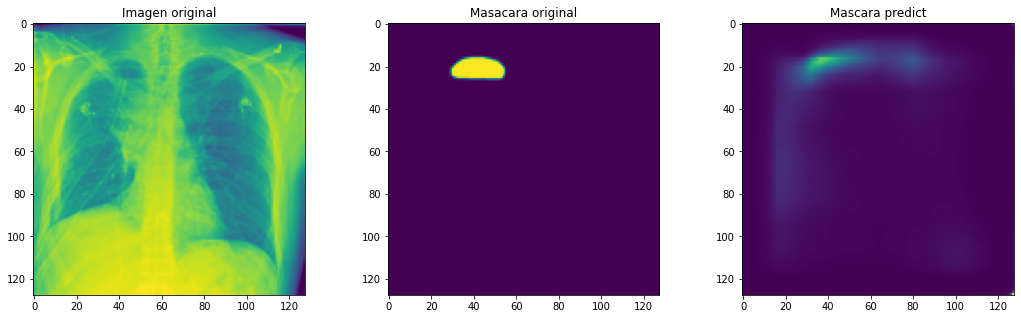

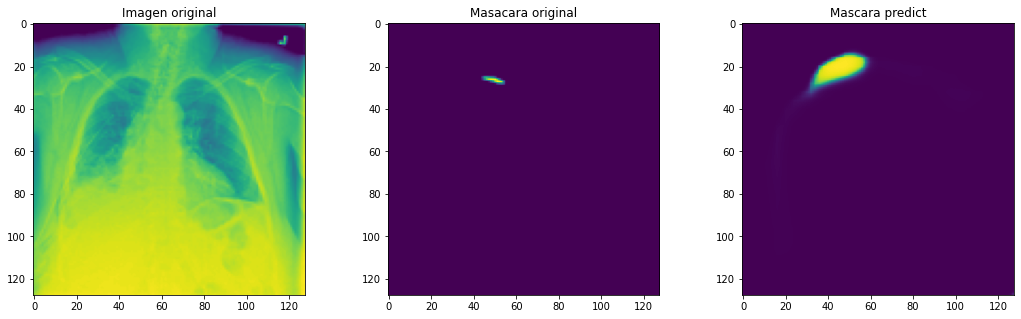

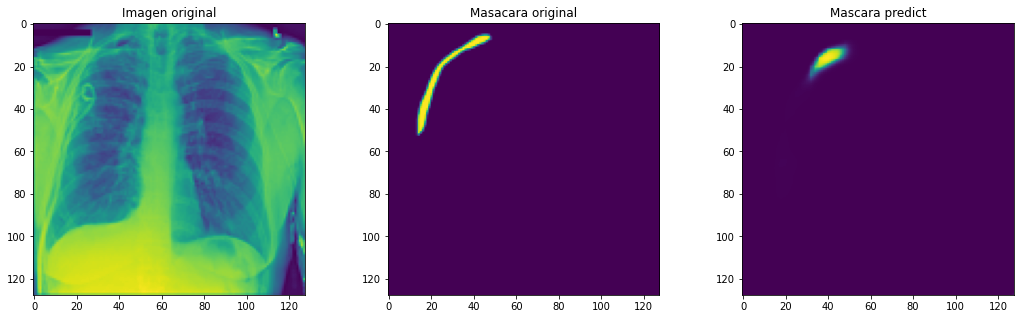

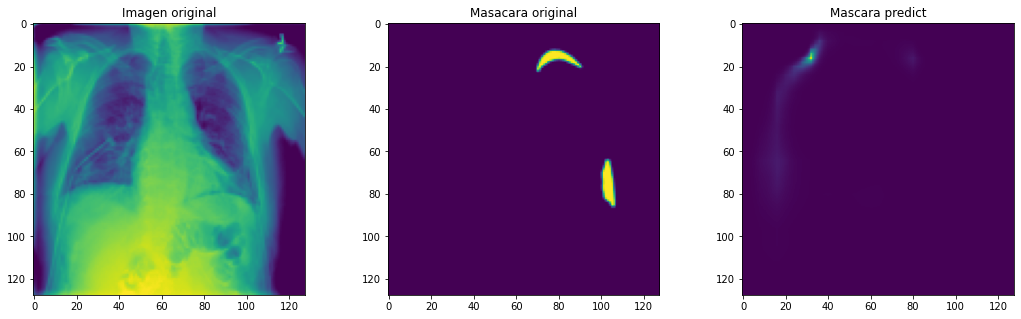

In [ ]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_1[0][0][idx].reshape(128,128))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_1[0][1][idx].reshape(128,128))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(128,128))
  ax3.set_title("Mascara predict")
  plt.show();

##Caso 4

* 64 imagenes, con Transform= True y epocs= 50

In [ ]:
pred_test = model.predict(datagen_test_1)

9/9 [==============================] - 86s 9s/step


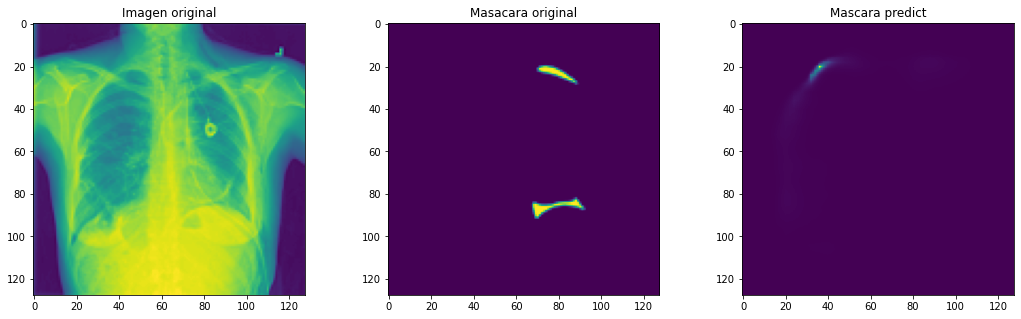

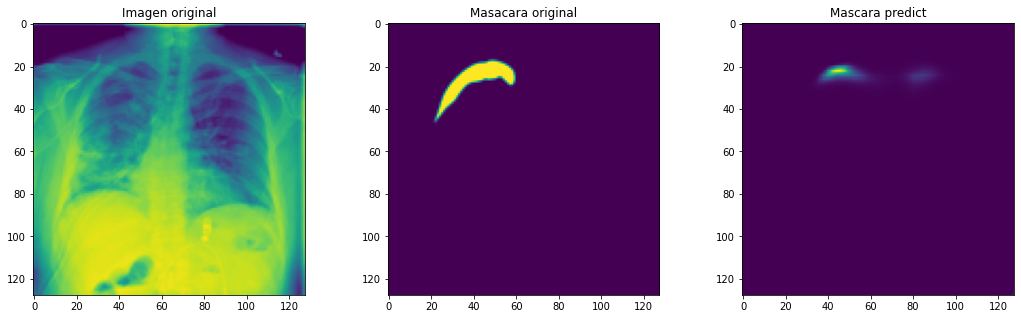

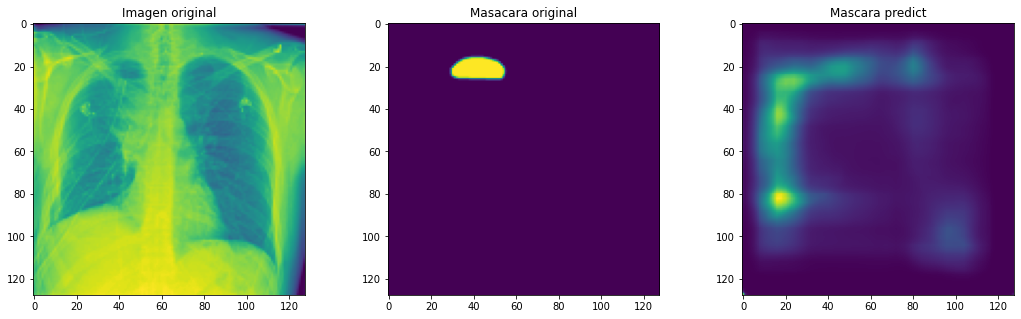

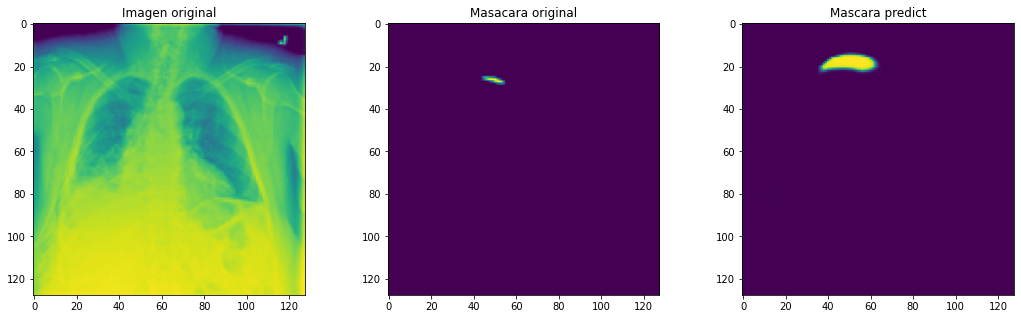

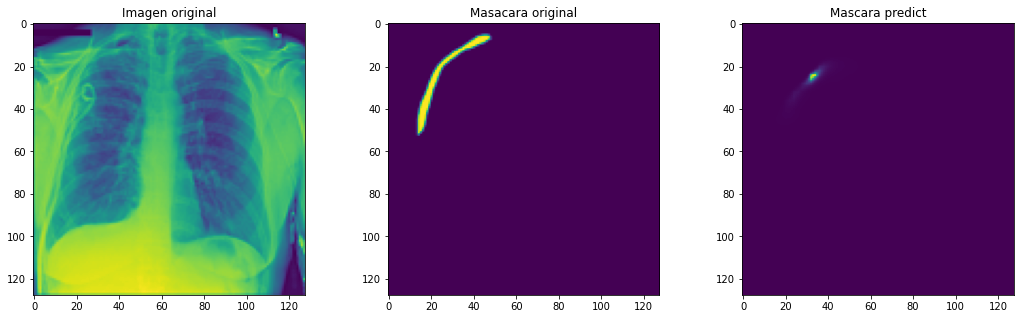

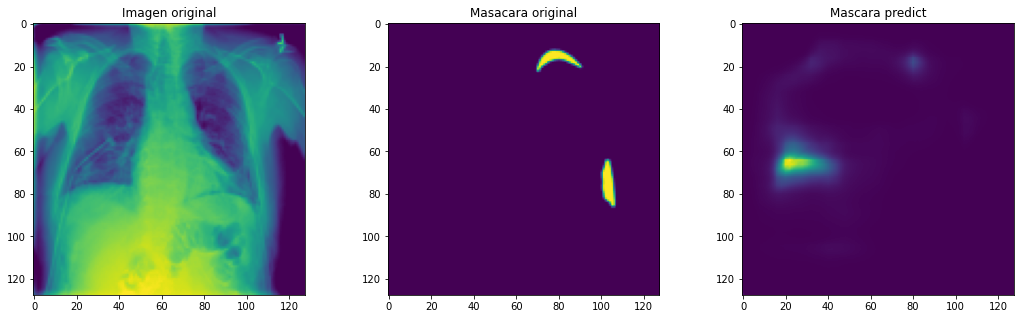

In [ ]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_1[0][0][idx].reshape(128,128))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_1[0][1][idx].reshape(128,128))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(128,128))
  ax3.set_title("Mascara predict")
  plt.show();

##Caso 5

* 2000 imagenes, con Transform= False y epocs= 20

In [ ]:
pred_test = model_2.predict(datagen_test_2)

4/4 [==============================] - 25s 5s/step


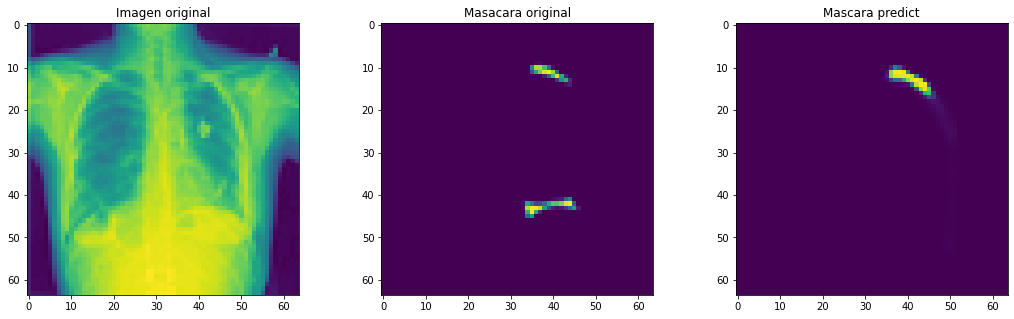

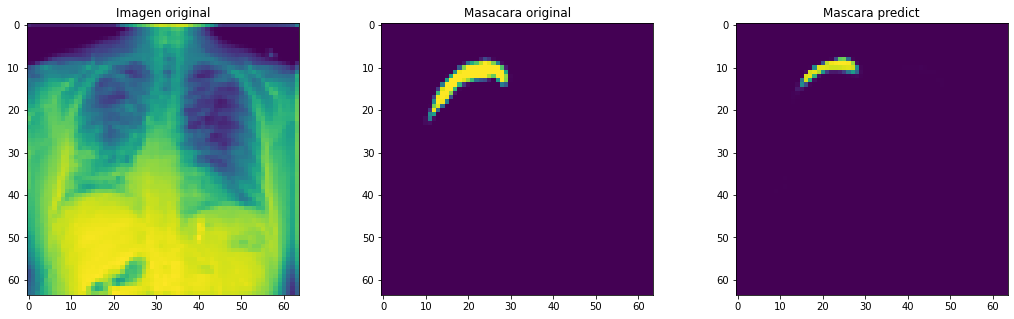

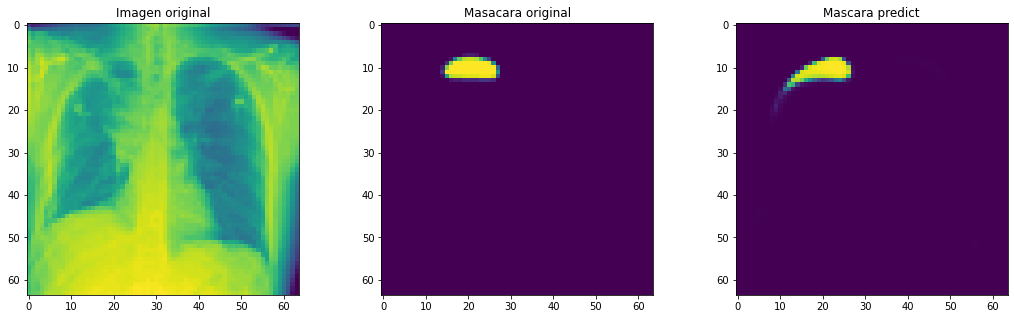

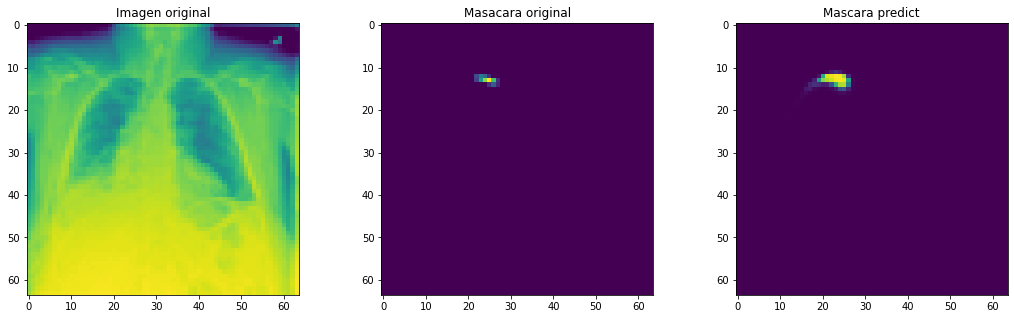

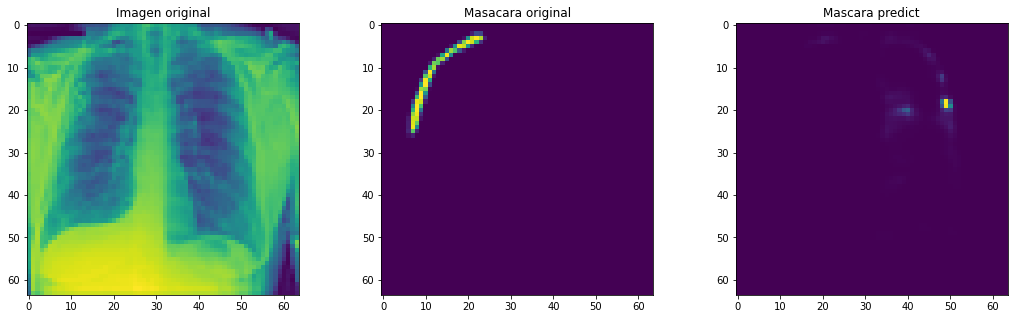

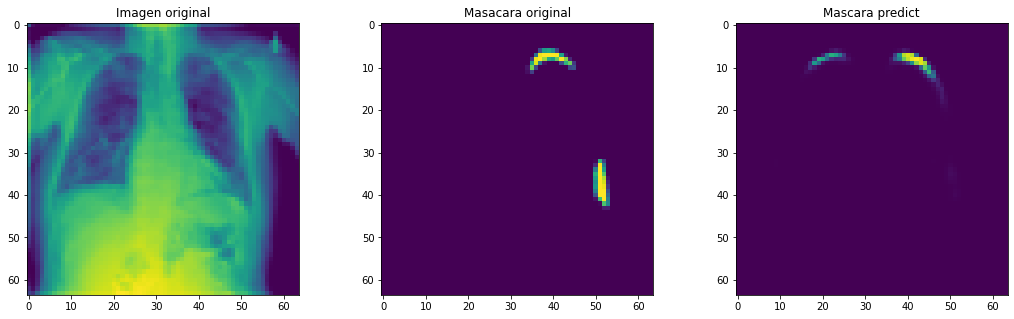

In [ ]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_2[0][0][idx].reshape(64,64))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_2[0][1][idx].reshape(64,64))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(64,64))
  ax3.set_title("Mascara predict")
  plt.show();

##Caso 6

* 2000 imagenes, con Transform= True y epocs= 20

In [ ]:
pred_test = model_2.predict(datagen_test_2)

4/4 [==============================] - 22s 5s/step


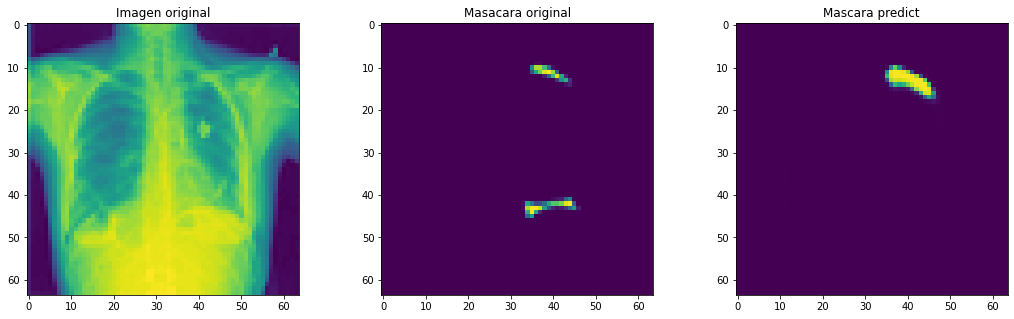

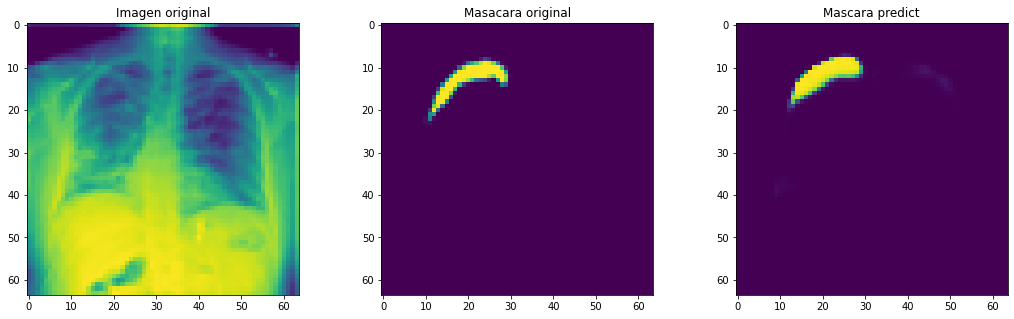

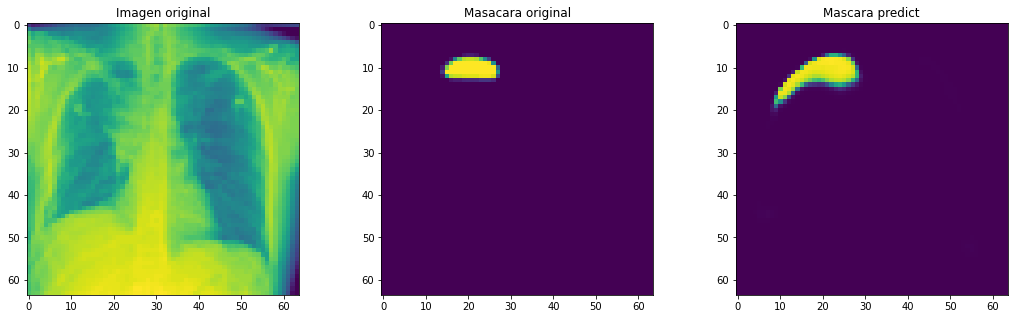

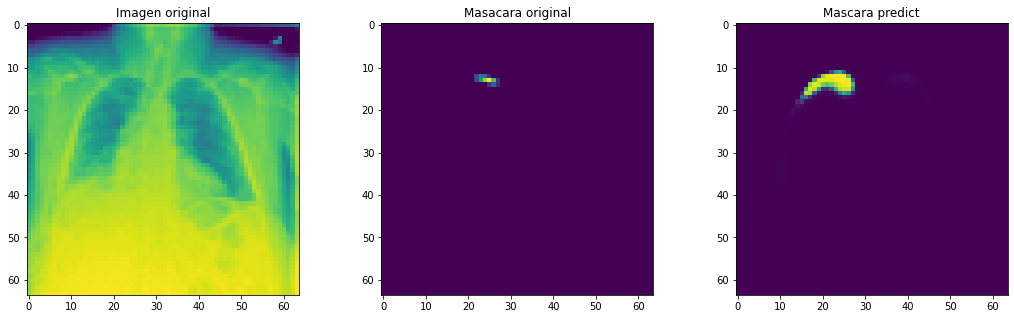

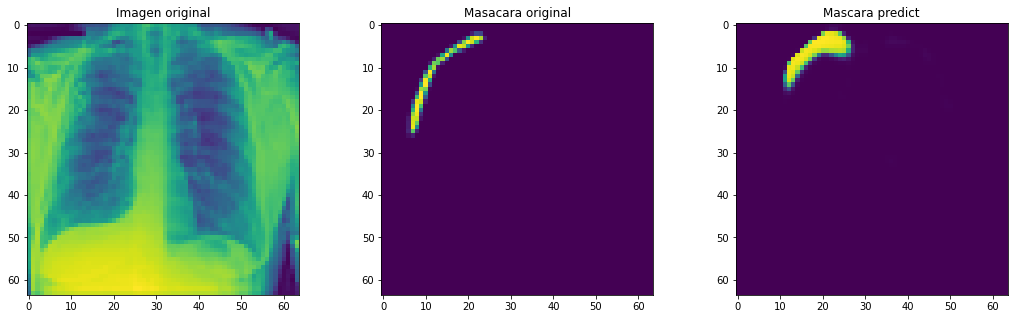

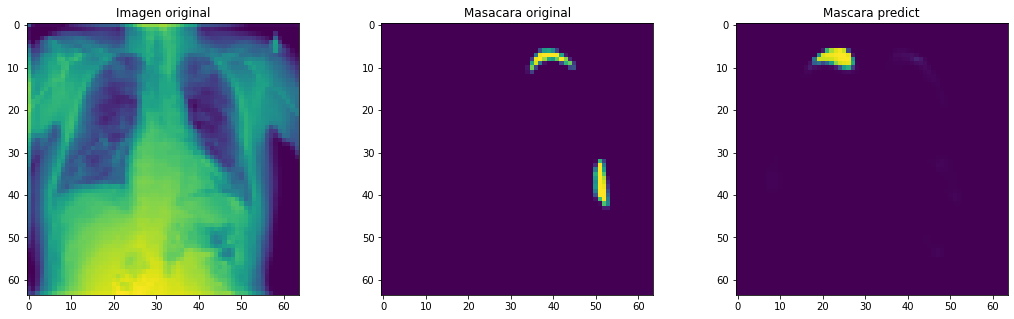

In [ ]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_2[0][0][idx].reshape(64,64))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_2[0][1][idx].reshape(64,64))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(64,64))
  ax3.set_title("Mascara predict")
  plt.show();

##Caso 7

* 2000 imagenes, con Transform= False y epocs= 50

In [25]:
pred_test = model_2.predict(datagen_test_2)

4/4 [==============================] - 110s 34s/step


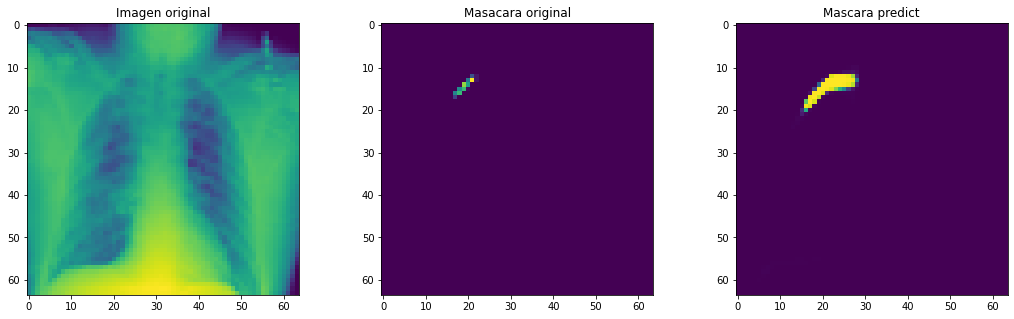

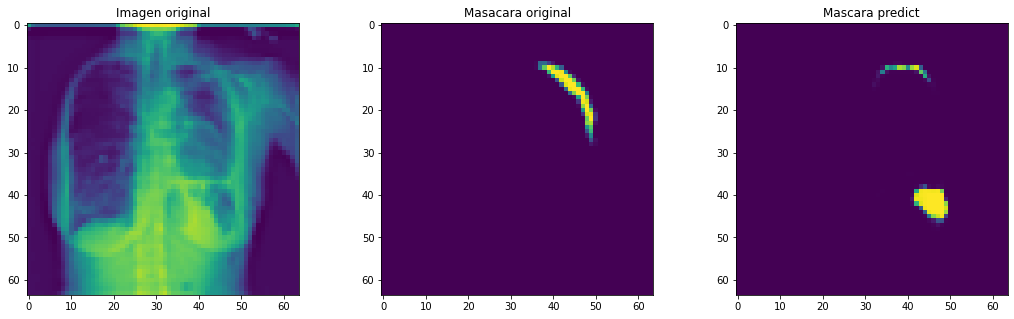

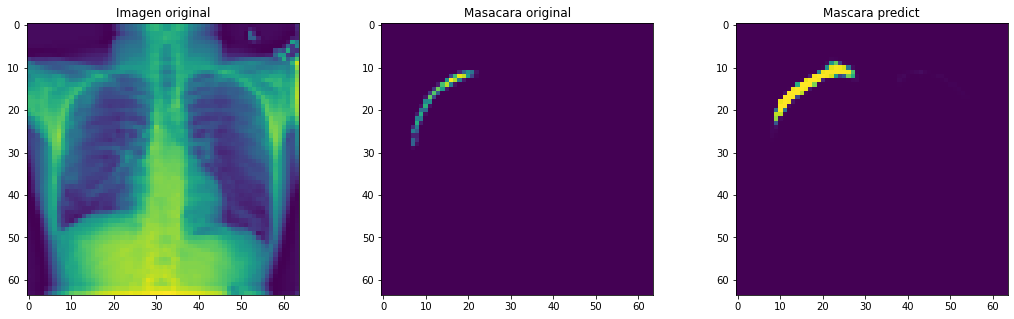

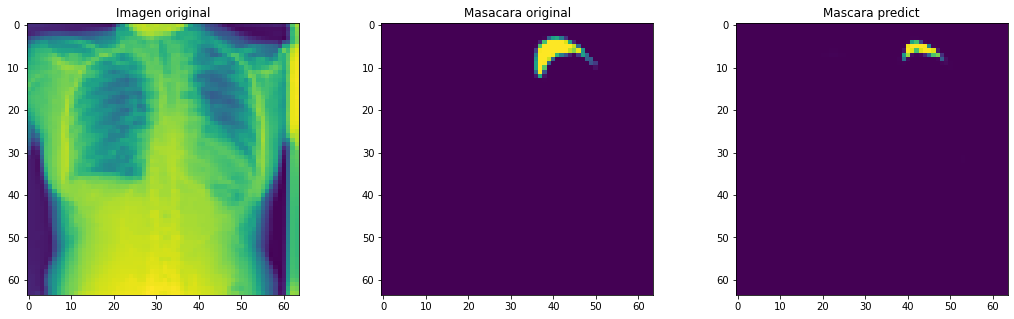

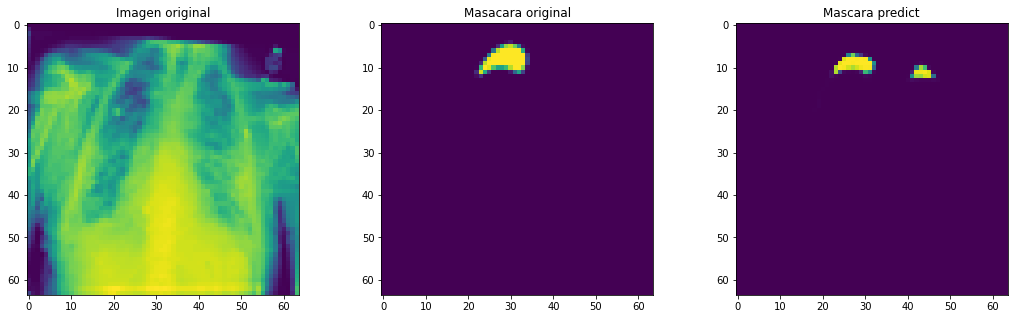

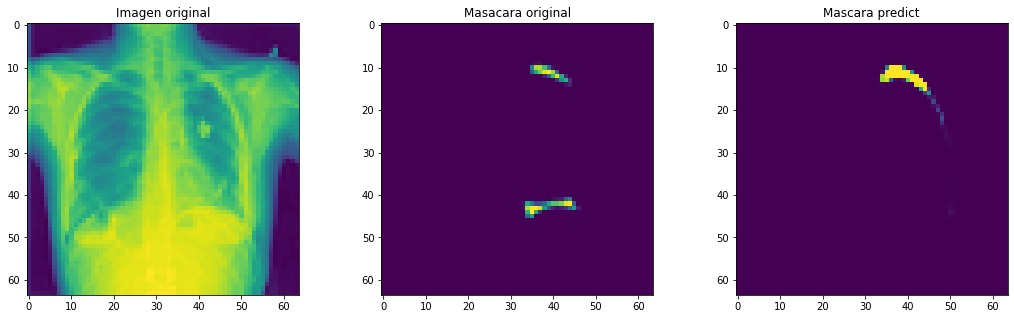

In [26]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_2[0][0][idx].reshape(64,64))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_2[0][1][idx].reshape(64,64))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(64,64))
  ax3.set_title("Mascara predict")
  plt.show();

##Caso 8

* 2000 imagenes, con Transform= True y epocs= 50

In [ ]:
pred_test = model_2.predict(datagen_test_2)

4/4 [==============================] - 23s 5s/step


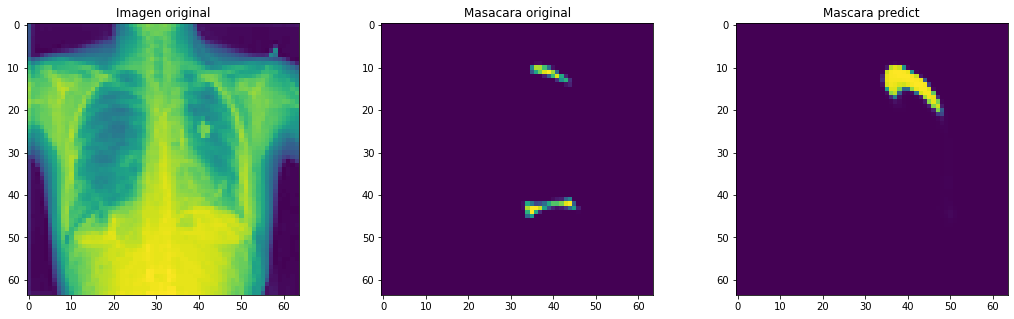

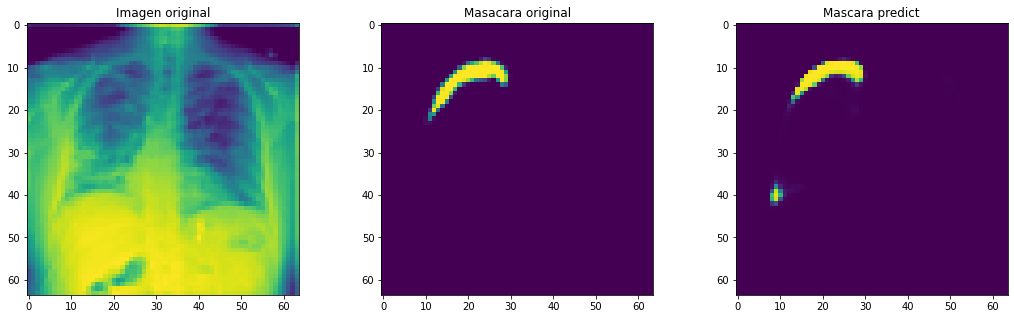

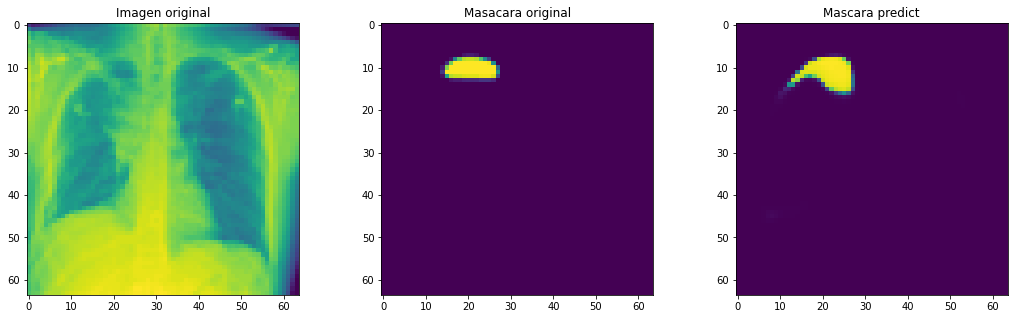

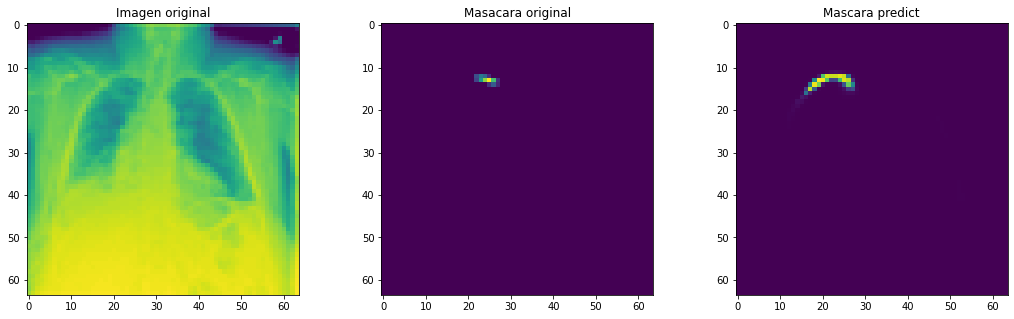

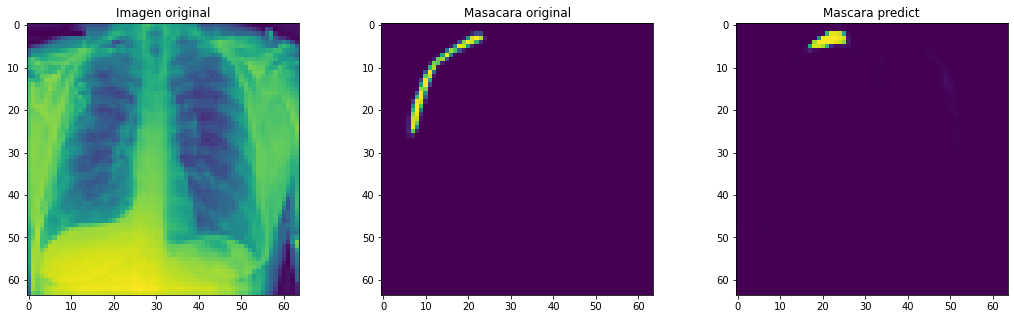

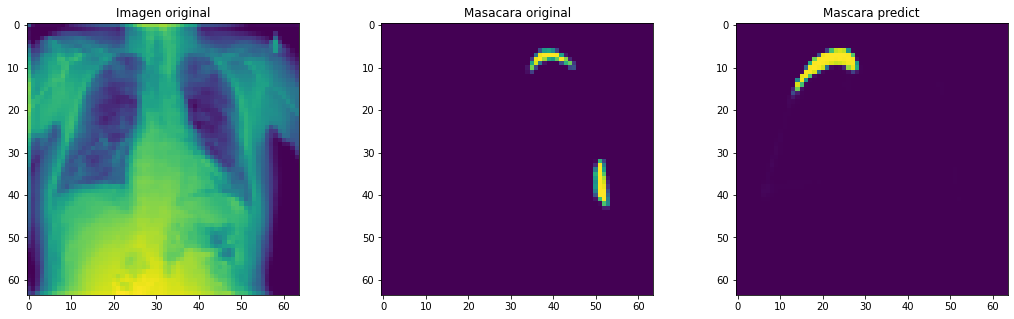

In [ ]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_2[0][0][idx].reshape(64,64))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_2[0][1][idx].reshape(64,64))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(64,64))
  ax3.set_title("Mascara predict")
  plt.show();

#Conclusion

Finalmente se puede decir que:

* Es mejor usar un dataset de 2000 que de 64, o por lo menos uno mas grade, ya que las curvas de loss no disminuyen tanto sino que mantienen una tendencia mas constante.

* Las funciones usadas en el transform no resultan una buena combinacion ya que el mejor caso (2000_epocs=50_Transform=False) no fue utilzando la transformacion. Puede ser que para este dataset no sea apropiado hacer transformaciones o tal vez no la combinacion que se hizo en este trabajo.

* Al usar un dataset mayor es mejor hacer mas cantidad de epocs, permite que la loss disminuya y el coeficiente de Dice aumente.

En conclusion, el mejor caso que se obtuvo fue el 7, donde se utlizo:
* dataset de 2000 imagenes
* 50 epochs
* Sin transformacion

Y dio como resultado:

* loss: 0.1502 
* binary_crossentropy: 0.0344 
* dice_coef: 0.7341 
* val_loss: 0.1460 
* val_binary_crossentropy: 0.0323 
* val_dice_coef: 0.7403
